**AB HIER BLOG QSD IV**

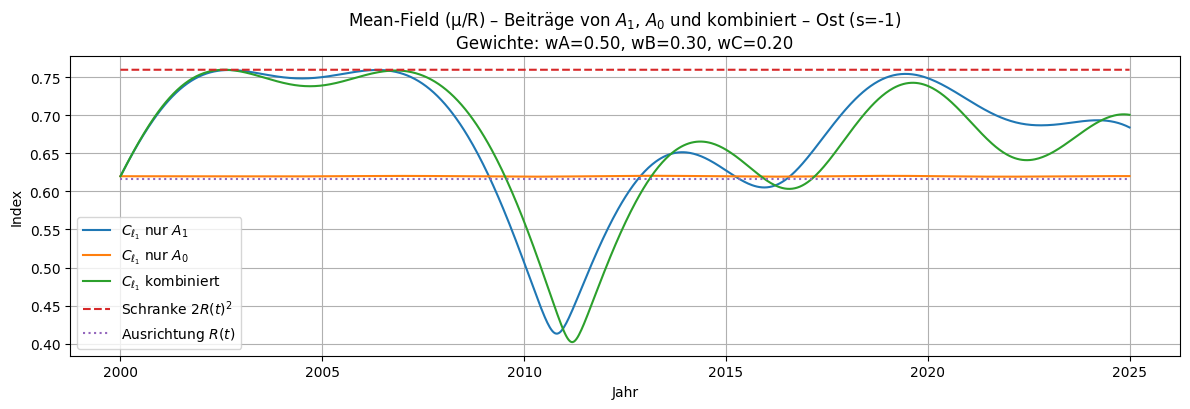

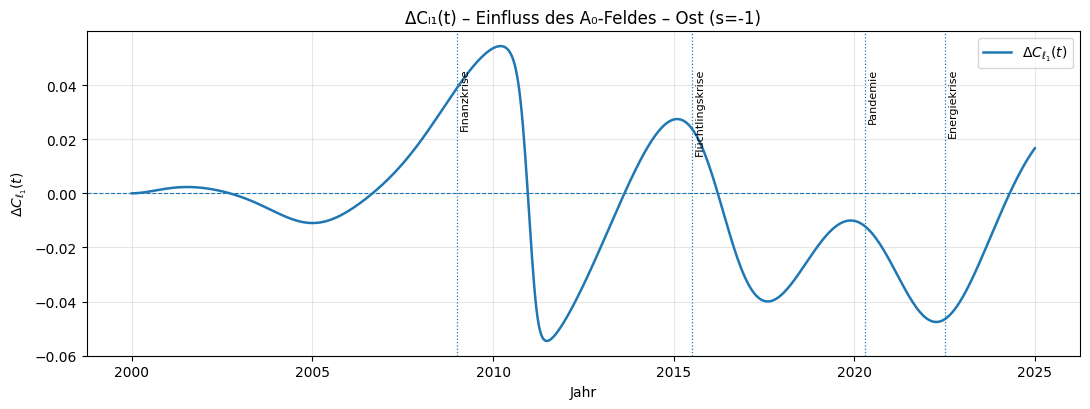


=== Ereignis-Korrelation ΔC_l1(t) – Ost (s=-1) ===
2009.0  Finanzkrise         ->  ΔC_l1 = +0.0392  -> verstärkte Kohärenz
2015.5  Flüchtlingskrise    ->  ΔC_l1 = +0.0242  -> verstärkte Kohärenz
2020.3  Pandemie            ->  ΔC_l1 = -0.0123  -> geschwächte Kohärenz
2022.5  Energiekrise        ->  ΔC_l1 = -0.0466  -> geschwächte Kohärenz



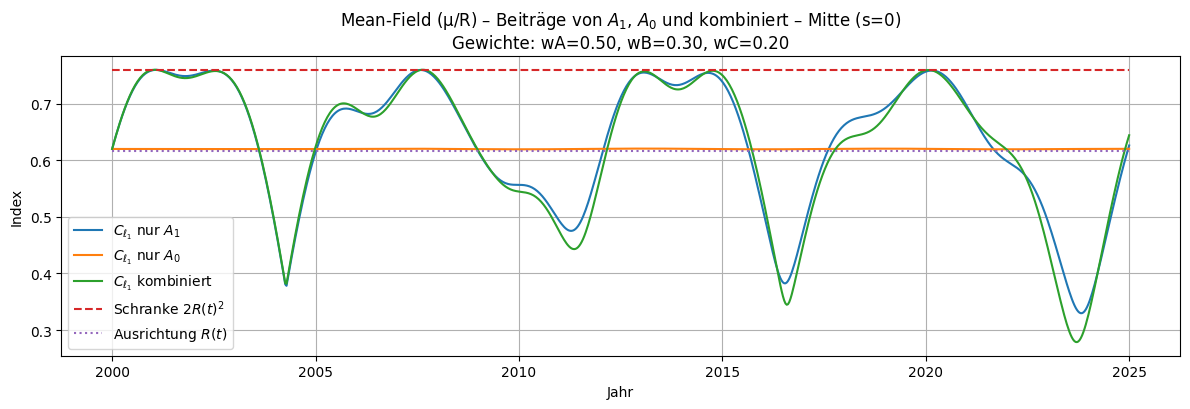

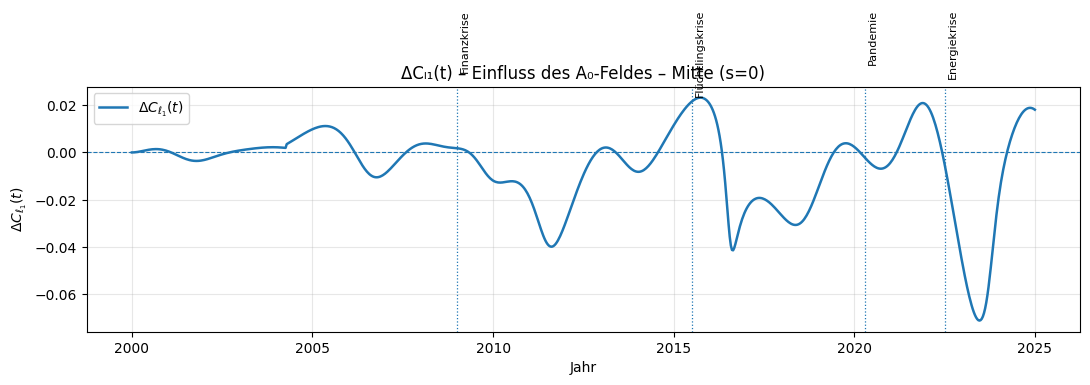


=== Ereignis-Korrelation ΔC_l1(t) – Mitte (s=0) ===
2009.0  Finanzkrise         ->  ΔC_l1 = +0.0018  -> verstärkte Kohärenz
2015.5  Flüchtlingskrise    ->  ΔC_l1 = +0.0213  -> verstärkte Kohärenz
2020.3  Pandemie            ->  ΔC_l1 = -0.0024  -> geschwächte Kohärenz
2022.5  Energiekrise        ->  ΔC_l1 = -0.0046  -> geschwächte Kohärenz



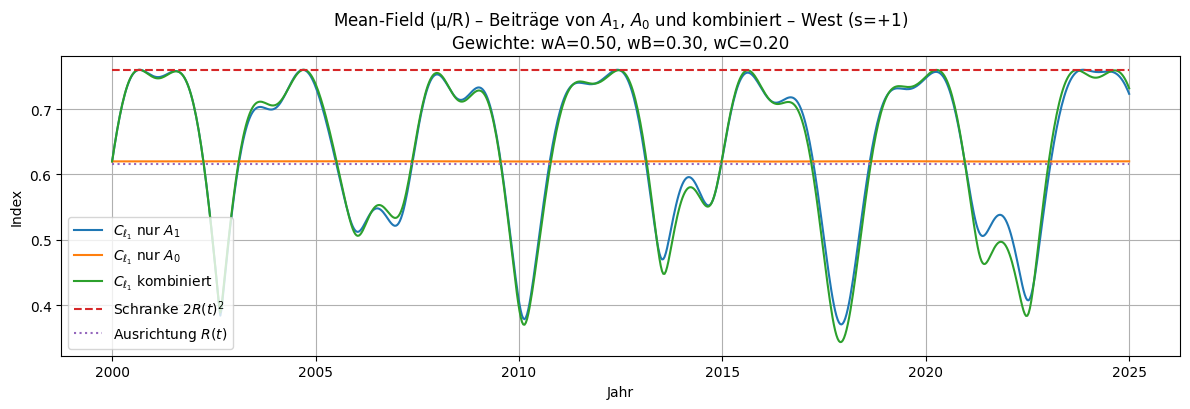

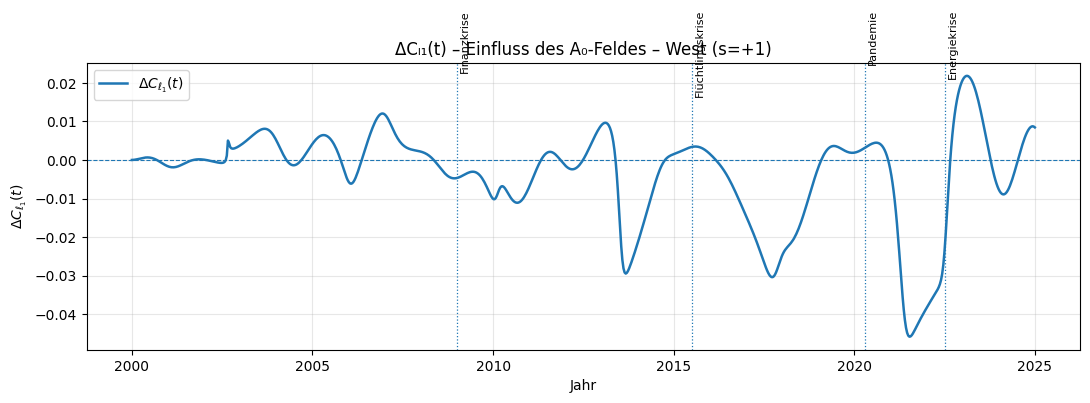


=== Ereignis-Korrelation ΔC_l1(t) – West (s=+1) ===
2009.0  Finanzkrise         ->  ΔC_l1 = -0.0047  -> geschwächte Kohärenz
2015.5  Flüchtlingskrise    ->  ΔC_l1 = +0.0033  -> verstärkte Kohärenz
2020.3  Pandemie            ->  ΔC_l1 = +0.0032  -> verstärkte Kohärenz
2022.5  Energiekrise        ->  ΔC_l1 = -0.0240  -> geschwächte Kohärenz



In [1]:
# -*- coding: utf-8 -*-
# ==== QSD: Mean-Field (μ/R) mit A0+A1, nichtlinearem u(s), v(s) ====
# - Regionen: Ost/Mitte/West via s ∈ {-1,0,+1}
# - Gewichte (wA,wB,wC) interpoliert über s
# - ΔC_l1(t) = C_l1^(A0+A1) - C_l1^(A1) + Ereignis-Korrelation
# - Nur matplotlib, keine festen Farben.

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

# ----------------------- A1: f_a(t) ---------------------------------------------------
years = np.array([2000, 2008, 2017, 2023, 2025], dtype=float)
f1_vals = np.array([0.6, 0.5, 0.4, 0.3, 0.25], dtype=float)
f2_vals = np.array([0.2, 0.23, 0.26, 0.28, 0.30], dtype=float)
f3_vals = np.array([0.1, 0.18, 0.25, 0.35, 0.40], dtype=float)
f4_vals = np.array([0.2, 0.22, 0.24, 0.30, 0.25], dtype=float)
f5_vals = np.array([0.2, 0.22, 0.25, 0.23, 0.22], dtype=float)
f6_vals = np.array([0.1, 0.12, 0.15, 0.18, 0.20], dtype=float)
f7_vals = np.array([0.3, 0.33, 0.36, 0.38, 0.40], dtype=float)
f8_vals = np.array([0.2, 0.18, 0.17, 0.16, 0.15], dtype=float)

fns = [None] + [interp1d(years, arr, kind='linear', fill_value='extrapolate')
                for arr in [f1_vals,f2_vals,f3_vals,f4_vals,f5_vals,f6_vals,f7_vals,f8_vals]]

def f_components(t: float) -> np.ndarray:
    return np.array([float(fns[i](t)) for i in range(1,9)], dtype=float)

# ----------------------- SU(3) Generatoren -------------------------------------------
L1 = np.array([[0,1,0],[1,0,0],[0,0,0]], complex)
L2 = np.array([[0,-1j,0],[1j,0,0],[0,0,0]], complex)
L3 = np.array([[1,0,0],[0,-1,0],[0,0,0]], complex)
L4 = np.array([[0,0,1],[0,0,0],[1,0,0]], complex)
L5 = np.array([[0,0,-1j],[0,0,0],[1j,0,0]], complex)
L6 = np.array([[0,0,0],[0,0,1],[0,1,0]], complex)
L7 = np.array([[0,0,0],[0,0,-1j],[0,1j,0]], complex)
L8 = (1/np.sqrt(3)) * np.diag([1,1,-2])
generators = [L1,L2,L3,L4,L5,L6,L7,L8]

# ----------------------- A0-Builder (Trend+Zyklen+Pulse, Orthogonalisierung) ---------
def _trend_linear(t, a=0.0, b=0.0, t_ref=2012.5): return a + b*(t - t_ref)
def _trend_sigmoid(t, amp=0.0, t0=2012.5, k=0.6): return amp * (2/(1+np.exp(-k*(t - t0))) - 1)
def _cycle(t, amp=0.0, period=8.0, phase=0.0): return amp * np.sin(2*np.pi*(t/period) + phase)
def _pulse_gauss(t, amp=0.0, t0=2020.0, sigma=1.0): return amp * np.exp(-0.5*((t - t0)/sigma)**2)

def _compose_a0(t, parts):
    y = np.zeros_like(t, dtype=float)
    if parts.get('linear'):  y += _trend_linear(t, **parts['linear'])
    if parts.get('sigmoid'): y += _trend_sigmoid(t, **parts['sigmoid'])
    for cyc in parts.get('cycles', []): y += _cycle(t, **cyc)
    for pls in parts.get('pulses', []): y += _pulse_gauss(t, **pls)
    return y

def _orthogonalize_against(f_fn, a0_array, t_grid):
    f_vec = np.array([float(f_fn(t)) for t in t_grid])
    a_vec = a0_array.copy()
    denom = float(np.dot(f_vec, f_vec))
    if denom < 1e-12: return a_vec
    proj = float(np.dot(a_vec, f_vec)) / denom
    return a_vec - proj * f_vec

A0_CONFIG = {
    8: dict(parts=dict(
            linear={'a':0.0, 'b':-0.004},
            sigmoid={'amp':0.05, 't0':2010.0, 'k':0.35},
            cycles=[{'amp':0.03, 'period':8.0, 'phase':0.3}],
            pulses=[{'amp':+0.05, 't0':2020.5, 'sigma':0.9},
                    {'amp':-0.03, 't0':2022.3, 'sigma':0.7}]),
       scale=1.0, orthogonalize_against_f=1, f_index=1),
    3: dict(parts=dict(
            linear={'a':0.0, 'b':+0.003},
            cycles=[{'amp':0.025, 'period':4.0, 'phase':-0.6}],
            pulses=[{'amp':+0.03, 't0':2016.0, 'sigma':1.0}]),
       scale=1.0, orthogonalize_against_f=1, f_index=3),
    1: dict(parts=dict(cycles=[{'amp':0.010, 'period':6.0, 'phase':0.0}]),
       scale=1.0, orthogonalize_against_f=0),
    6: dict(parts=dict(cycles=[{'amp':0.008, 'period':5.0, 'phase':1.2}]),
       scale=1.0, orthogonalize_against_f=0),
}

def make_a0_model(config=A0_CONFIG, t_min=2000.0, t_max=2025.0, n_fit=600):
    t_grid = np.linspace(t_min, t_max, n_fit)
    a0_time_series = {a: np.zeros_like(t_grid, dtype=float) for a in range(1,9)}
    for a, spec in config.items():
        parts = spec.get('parts', {})
        series = _compose_a0(t_grid, parts) * float(spec.get('scale', 1.0))
        if spec.get('orthogonalize_against_f', 0):
            f_fn = fns[int(spec.get('f_index', a))]
            series = _orthogonalize_against(f_fn, series, t_grid)
        a0_time_series[a] = series
    a0_funcs = []
    for a in range(1,9):
        fn = interp1d(t_grid, a0_time_series[a], kind='linear', fill_value='extrapolate')
        a0_funcs.append(fn)
    return a0_funcs

a0_1, a0_2, a0_3, a0_4, a0_5, a0_6, a0_7, a0_8 = make_a0_model()

def a0_components(t: float) -> np.ndarray:
    return np.array([float(fn(t)) for fn in [a0_1,a0_2,a0_3,a0_4,a0_5,a0_6,a0_7,a0_8]], dtype=float)

# ----------------------- Profile u(s), v(s)  (nichtlinear v) -------------------------
alpha_u = 0.60            # Strukturgradient
alpha_v = 0.50            # lineare Komponente v
base_v  = 1.50            # Ost-Peak Basis
k_v     = 0.40            # Krümmung
eta_v   = 0.50            # Blend: 0 (linear) .. 1 (Ost-Peak)

def u_of_s(s: float) -> float:
    return 1.0 + alpha_u * s

def v_linear(s: float) -> float:
    return 1.0 + alpha_v * s

def v_local_east(s: float) -> float:
    return base_v - k_v*(s+1.0)**2

def v_of_s(s: float, eta: float = eta_v) -> float:
    return (1-eta)*v_linear(s) + eta*v_local_east(s)

# ----------------------- A1, A0, Hamiltonian -----------------------------------------
def A1_of_t_s(t: float, s: float) -> np.ndarray:
    A = np.zeros((3,3), dtype=complex); fa=f_components(t); us=u_of_s(s)
    for a in range(8): A += us * fa[a] * generators[a]
    return A

def A0_of_t_s(t: float, s: float) -> np.ndarray:
    A = np.zeros((3,3), dtype=complex); ca=a0_components(t); vs=v_of_s(s)
    for a in range(8): A += vs * ca[a] * generators[a]
    return A

def H_of_t_s(t: float, s: float, g0: float, g1: float) -> np.ndarray:
    return g0 * A0_of_t_s(t, s) + g1 * A1_of_t_s(t, s)

# ----------------------- Schrödinger-Dynamik -----------------------------------------
def schrodinger_rhs(t, psi_flat, s: float, g0: float, g1: float):
    psi = psi_flat[:3] + 1j*psi_flat[3:]
    H = H_of_t_s(t, s, g0, g1)
    dpsi = -1j * H @ psi
    return np.concatenate([dpsi.real, dpsi.imag])

def evolve_state(psi0: np.ndarray, s: float, g0: float, g1: float,
                 t0: float = 2000.0, t1: float = 2025.0, n_eval: int = 800):
    y0 = np.concatenate([psi0.real, psi0.imag])
    t_eval = np.linspace(t0, t1, n_eval)
    sol = solve_ivp(
        schrodinger_rhs, [t0, t1], y0,
        t_eval=t_eval, rtol=1e-8, atol=1e-10, method='DOP853',
        args=(s, g0, g1)
    )
    psi_t = sol.y[:3, :] + 1j*sol.y[3:, :]
    norms = np.maximum(1e-14, np.linalg.norm(psi_t, axis=0, keepdims=True))
    psi_t = psi_t / norms
    return t_eval, psi_t.T

def normalize_path(P):
    n = np.maximum(1e-14, np.linalg.norm(P, axis=1, keepdims=True))
    return P / n

# ----------------------- Gewichte: Ost/West-Interpolation ----------------------------
# West: (0.5, 0.3, 0.2)   Ost: (0.7, 0.2, 0.1)  -> Mitte: linearer Blend
W_WEST = np.array([0.5, 0.3, 0.2], dtype=float)
W_EAST = np.array([0.5, 0.3, 0.2], dtype=float)

def weights_of_s(s: float):
    w = ((1-s)/2.0)*W_EAST + ((1+s)/2.0)*W_WEST
    w = np.clip(w, 0.0, 1.0)
    w = w / (np.sum(w) + 1e-15)
    return float(w[0]), float(w[1]), float(w[2])

# ----------------------- Mean-Field EXAKT (μ/R) --------------------------------------
def mean_field_C_l1_weighted(t_eval, pathA, pathB, pathC, wA, wB, wC):
    T = len(t_eval)
    C_mf = np.empty(T); R_ser = np.empty(T)
    for k in range(T):
        a, b, c = pathA[k], pathB[k], pathC[k]
        mu = wA*a + wB*b + wC*c
        R  = np.linalg.norm(mu)
        mu_hat = mu / (R + 1e-15)
        C_mf[k] = R**2 * ( (np.sum(np.abs(mu_hat)))**2 - 1.0 )
        R_ser[k] = R
    C_bound = 2.0 * (R_ser**2)
    return C_mf, C_bound, R_ser

# ----------------------- Szenarien ----------------------------------------------------
SCENARIOS = [
    ("nur A1", dict(g0=0.0, g1=1.0)),
    ("nur A0", dict(g0=0.5, g1=0.0)),
    ("kombiniert", dict(g0=0.5, g1=1.0)),
]

# ----------------------- Ereignisse (für ΔC-Overlay) --------------------------------
EVENTS = {
    2009: "Finanzkrise",
    2015.5: "Flüchtlingskrise",
    2020.3: "Pandemie",
    2022.5: "Energiekrise"
}

def plot_region_meanfield(s_val: float, region_name: str):
    wA, wB, wC = weights_of_s(s_val)
    psiA0 = np.array([1,0,0], complex)  # Blau
    psiB0 = np.array([0,1,0], complex)  # Orange
    psiC0 = np.array([0,0,1], complex)  # Grün

    C_series = {}
    for name, pars in SCENARIOS:
        t_eval, pathA = evolve_state(psiA0, s_val, pars["g0"], pars["g1"])
        _,      pathB = evolve_state(psiB0, s_val, pars["g0"], pars["g1"])
        _,      pathC = evolve_state(psiC0, s_val, pars["g0"], pars["g1"])
        pathA = normalize_path(pathA); pathB = normalize_path(pathB); pathC = normalize_path(pathC)

        C_mf, C_bound, R_ser = mean_field_C_l1_weighted(t_eval, pathA, pathB, pathC, wA, wB, wC)
        C_series[name] = (C_mf, C_bound, R_ser)

    # Plot C_l1 nur A1 / nur A0 / kombiniert + 2R^2 + R(t)
    plt.figure(figsize=(12, 4.2))
    plt.plot(t_eval, C_series["nur A1"][0], label=r"$C_{\ell_1}$ nur $A_1$")
    plt.plot(t_eval, C_series["nur A0"][0], label=r"$C_{\ell_1}$ nur $A_0$")
    plt.plot(t_eval, C_series["kombiniert"][0], label=r"$C_{\ell_1}$ kombiniert")
    plt.plot(t_eval, C_series["kombiniert"][1], linestyle="--", label=r"Schranke $2R(t)^2$")
    plt.plot(t_eval, C_series["kombiniert"][2], linestyle=":",  label=r"Ausrichtung $R(t)$")
    plt.xlabel("Jahr"); plt.ylabel("Index")
    plt.title(f"Mean-Field (μ/R) – Beiträge von $A_1$, $A_0$ und kombiniert – {region_name}\n"
              f"Gewichte: wA={wA:.2f}, wB={wB:.2f}, wC={wC:.2f}")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    return t_eval, C_series

def plot_delta_and_correl(t_eval, C_series, region_name: str):
    C_A1 = C_series["nur A1"][0]
    C_comb = C_series["kombiniert"][0]
    delta_C = C_comb - C_A1

    plt.figure(figsize=(11, 4.2))
    plt.plot(t_eval, delta_C, linewidth=1.8, label=r"$\Delta C_{\ell_1}(t)$")
    plt.axhline(0, linestyle='--', linewidth=0.8)

    # Ereignisse markieren
    ymax = np.max(np.abs(delta_C)) if np.max(np.abs(delta_C))>0 else 1.0
    for year, label in EVENTS.items():
        plt.axvline(year, linestyle=':', linewidth=0.9)
        plt.text(year+0.08, 0.85*ymax, label, rotation=90, fontsize=8, va='top')

    plt.title(f"ΔCₗ₁(t) – Einfluss des A₀-Feldes – {region_name}")
    plt.xlabel("Jahr"); plt.ylabel(r"$\Delta C_{\ell_1}(t)$")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    # Konsole: Werte an Ereignisjahren
    print("\n=== Ereignis-Korrelation ΔC_l1(t) –", region_name, "===")
    for year, label in EVENTS.items():
        idx = np.argmin(np.abs(t_eval - year))
        val = float(delta_C[idx])
        trend = "verstärkte Kohärenz" if val > 0 else "geschwächte Kohärenz"
        print(f"{year:6.1f}  {label:18s}  ->  ΔC_l1 = {val:+.4f}  -> {trend}")
    print("=====================================================\n")

# ----------------------- HAUPT: drei Regionen durchlaufen ----------------------------
for s_val, region in [(-1.0,"Ost (s=-1)"), (0.0,"Mitte (s=0)"), (1.0,"West (s=+1)")]:
    t_eval, C_series = plot_region_meanfield(s_val, region)
    plot_delta_and_correl(t_eval, C_series, region)


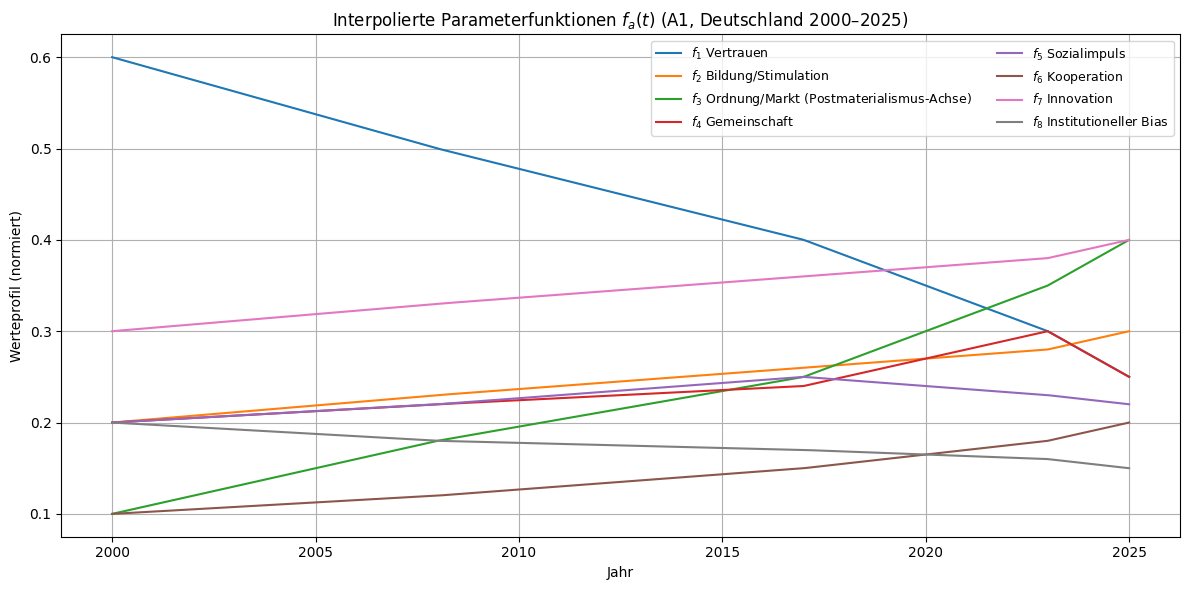

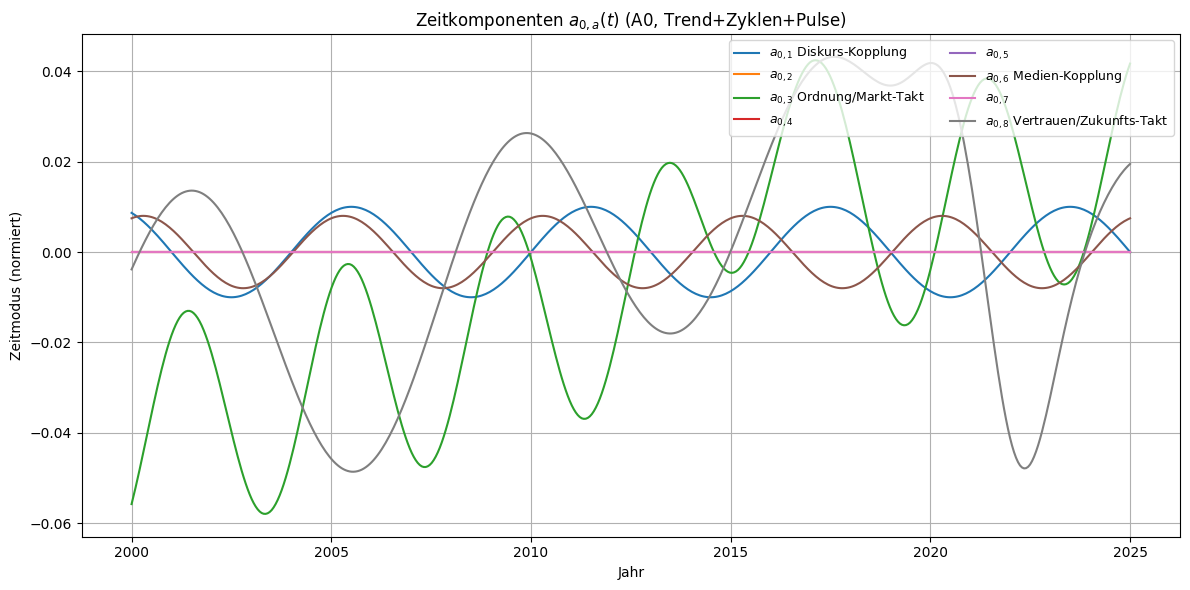

In [ ]:
# ==== ADD-ON 1: Zeitverläufe f_a(t) und a0_a(t) ===============================
# Voraussetzungen aus Hauptprogramm:
# - f_components(t: float) -> np.ndarray  (8 Werte)
# - a0_components(t: float) -> np.ndarray (8 Werte)

import numpy as np
import matplotlib.pyplot as plt

def plot_f_parameters(t_min=2000.0, t_max=2025.0, n=500):
    t = np.linspace(t_min, t_max, n)
    F = np.vstack([f_components(tt) for tt in t])  # (n,8)
    labels_f = [
        r"$f_1$ Vertrauen",
        r"$f_2$ Bildung/Stimulation",
        r"$f_3$ Ordnung/Markt (Postmaterialismus-Achse)",
        r"$f_4$ Gemeinschaft",
        r"$f_5$ Sozialimpuls",
        r"$f_6$ Kooperation",
        r"$f_7$ Innovation",
        r"$f_8$ Institutioneller Bias",
    ]
    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.plot(t, F[:, i], label=labels_f[i])
    plt.title(r"Interpolierte Parameterfunktionen $f_a(t)$ (A1, Deutschland 2000–2025)")
    plt.xlabel("Jahr"); plt.ylabel("Werteprofil (normiert)")
    plt.grid(True); plt.legend(loc="upper right", ncol=2, fontsize=9)
    plt.tight_layout(); plt.show()

def plot_a0_components(t_min=2000.0, t_max=2025.0, n=500):
    t = np.linspace(t_min, t_max, n)
    A0 = np.vstack([a0_components(tt) for tt in t])  # (n,8)
    labels_a0 = [
        r"$a_{0,1}$ Diskurs-Kopplung",
        r"$a_{0,2}$",
        r"$a_{0,3}$ Ordnung/Markt-Takt",
        r"$a_{0,4}$",
        r"$a_{0,5}$",
        r"$a_{0,6}$ Medien-Kopplung",
        r"$a_{0,7}$",
        r"$a_{0,8}$ Vertrauen/Zukunfts-Takt",
    ]
    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.plot(t, A0[:, i], label=labels_a0[i])
    plt.title(r"Zeitkomponenten $a_{0,a}(t)$ (A0, Trend+Zyklen+Pulse)")
    plt.xlabel("Jahr"); plt.ylabel("Zeitmodus (normiert)")
    plt.grid(True); plt.legend(loc="upper right", ncol=2, fontsize=9)
    plt.tight_layout(); plt.show()

# --- Beispielaufrufe:
plot_f_parameters()
plot_a0_components()


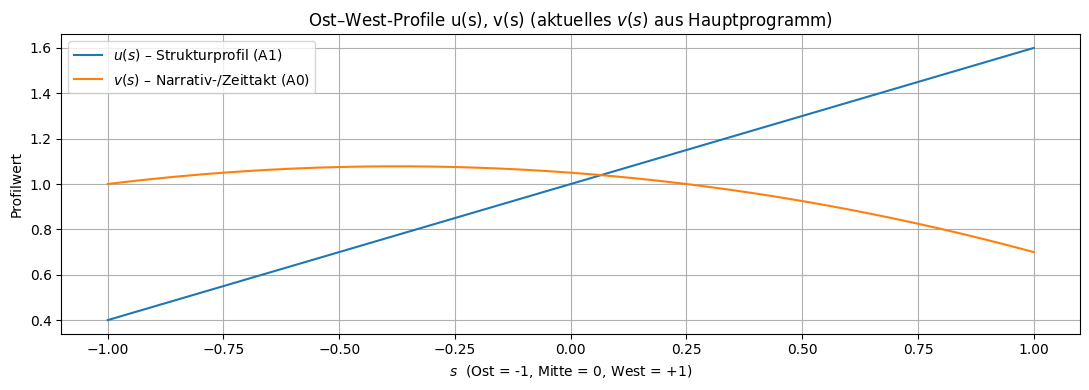

In [ ]:
# ==== ADD-ON 2: Ortsprofile u(s) und v(s) =====================================
# Voraussetzungen aus Hauptprogramm:
# - u_of_s(s: float) -> float
# - v_of_s(s: float, eta: float = eta_v) -> float
# - globale Variable eta_v (oder eigenen Wert übergeben)

import numpy as np
import matplotlib.pyplot as plt

def plot_profiles_uv(s_min=-1.0, s_max=+1.0, n=401, eta=None):
    s = np.linspace(s_min, s_max, n)
    # Falls eta nicht gesetzt, v_of_s so verwenden, wie im Hauptprogramm definiert ist
    if eta is None:
        u_vals = np.array([u_of_s(si) for si in s])
        v_vals = np.array([v_of_s(si) for si in s])
        subtitle = r"(aktuelles $v(s)$ aus Hauptprogramm)"
    else:
        u_vals = np.array([u_of_s(si) for si in s])
        v_vals = np.array([v_of_s(si, eta=eta) for si in s])
        subtitle = rf"(mit Vorgabe $\eta={eta:.2f}$)"

    plt.figure(figsize=(11,4))
    plt.plot(s, u_vals, label=r"$u(s)$ – Strukturprofil (A1)")
    plt.plot(s, v_vals, label=r"$v(s)$ – Narrativ-/Zeittakt (A0)")
    plt.xlabel(r"$s$  (Ost = -1, Mitte = 0, West = +1)")
    plt.ylabel("Profilwert")
    plt.title("Ost–West-Profile u(s), v(s) " + subtitle)
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

# --- Beispielaufrufe:
plot_profiles_uv()
#plot_profiles_uv(eta=0.20)  # z.B. stärkerer Ost-Peak in v(s)


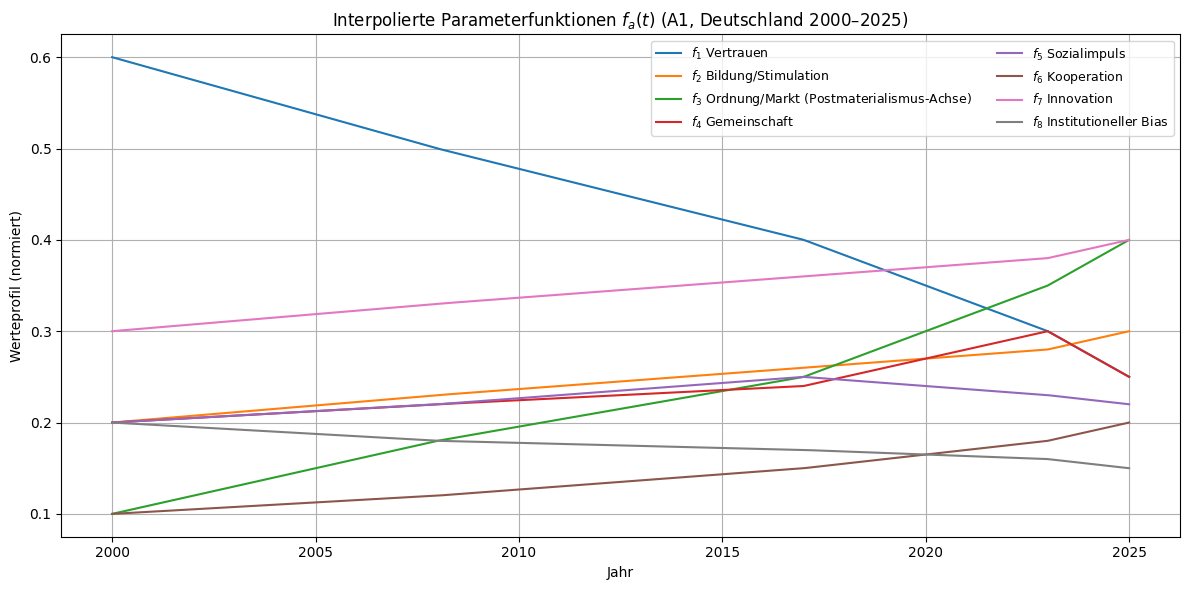

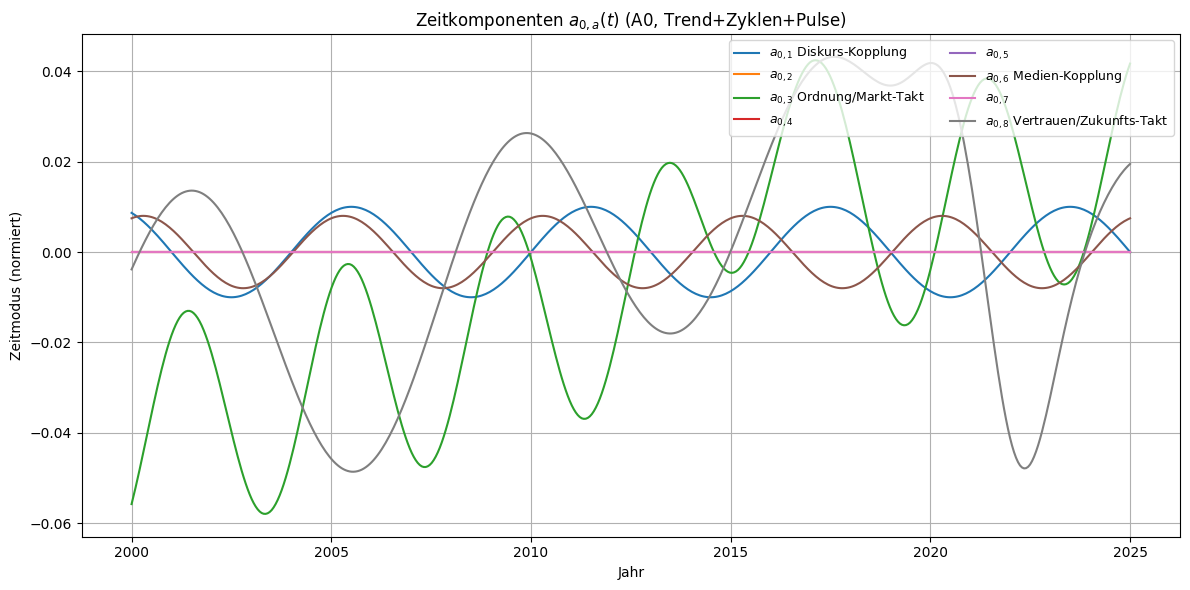

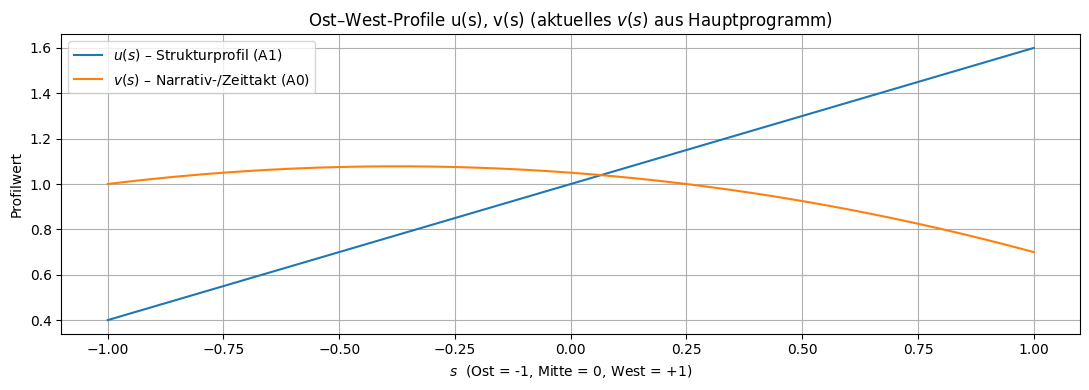

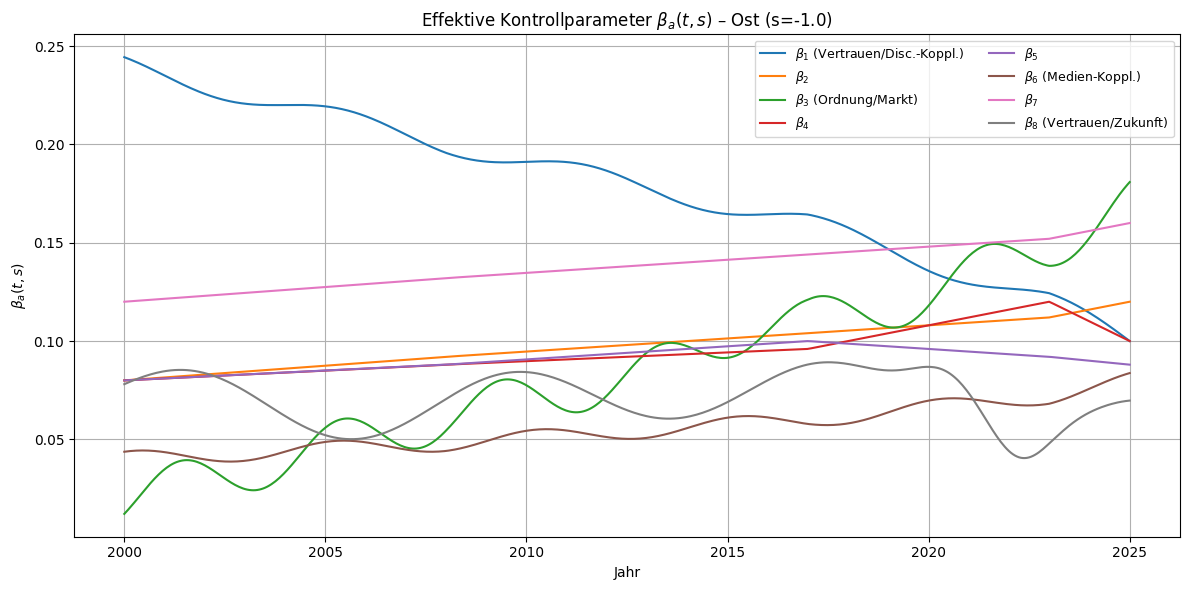

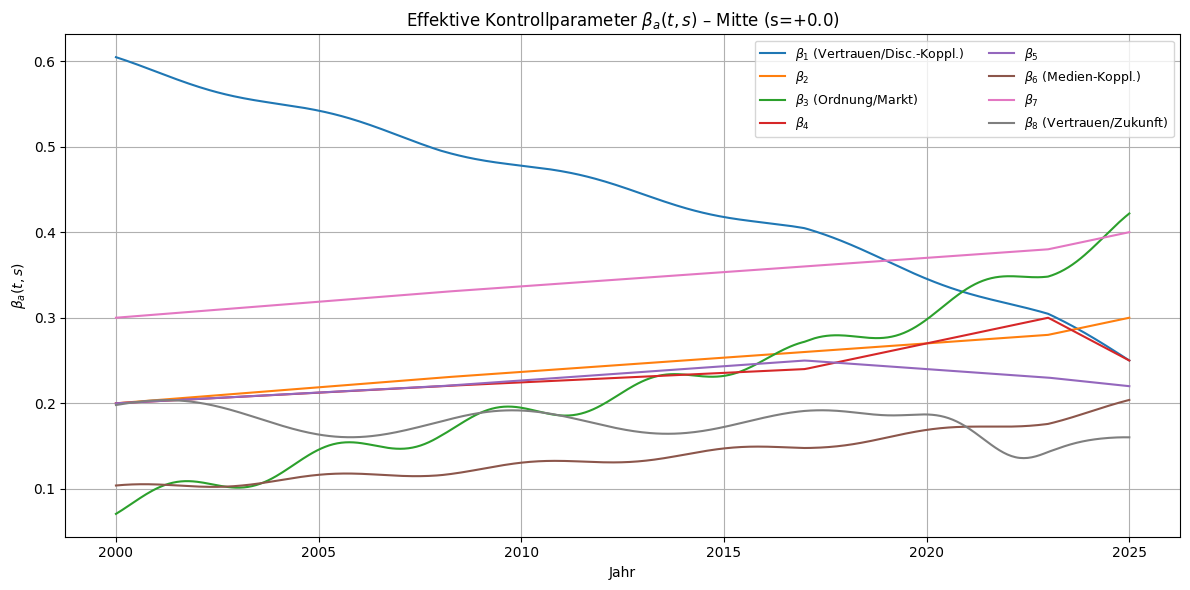

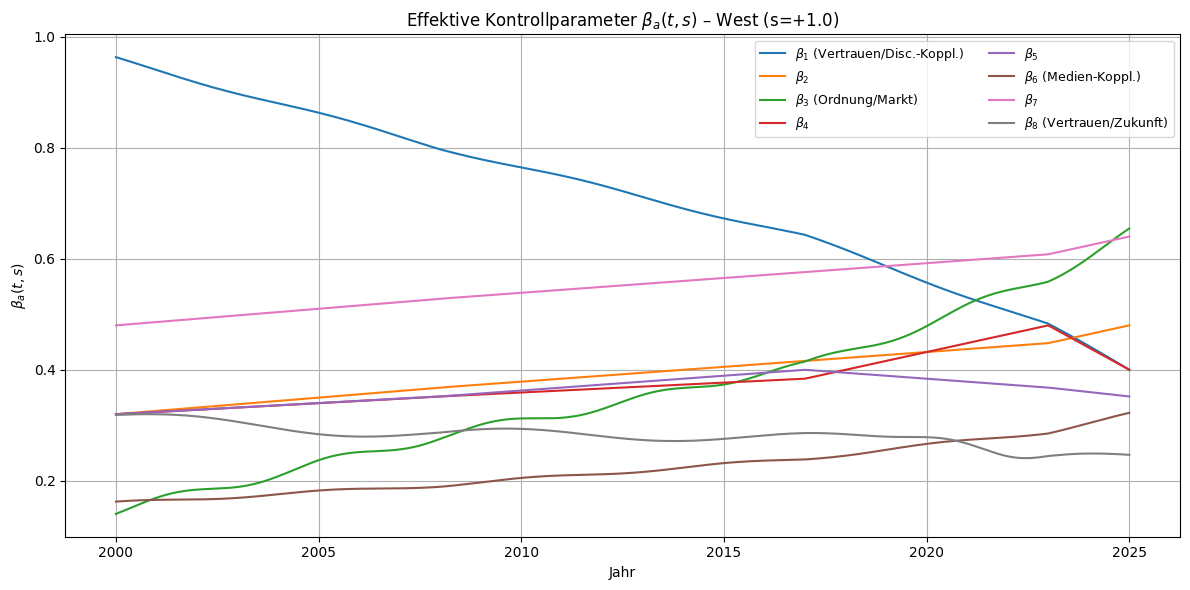

In [ ]:
# ==== ADD-ON 1, 2 plus effektiver Kontrollparameter ===============================
# Voraussetzungen aus Hauptprogramm:
# - f_components(t: float) -> np.ndarray  (8 Werte)
# - a0_components(t: float) -> np.ndarray (8 Werte)

import numpy as np
import matplotlib.pyplot as plt

def plot_f_parameters(t_min=2000.0, t_max=2025.0, n=500):
    t = np.linspace(t_min, t_max, n)
    F = np.vstack([f_components(tt) for tt in t])  # (n,8)
    labels_f = [
        r"$f_1$ Vertrauen",
        r"$f_2$ Bildung/Stimulation",
        r"$f_3$ Ordnung/Markt (Postmaterialismus-Achse)",
        r"$f_4$ Gemeinschaft",
        r"$f_5$ Sozialimpuls",
        r"$f_6$ Kooperation",
        r"$f_7$ Innovation",
        r"$f_8$ Institutioneller Bias",
    ]
    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.plot(t, F[:, i], label=labels_f[i])
    plt.title(r"Interpolierte Parameterfunktionen $f_a(t)$ (A1, Deutschland 2000–2025)")
    plt.xlabel("Jahr"); plt.ylabel("Werteprofil (normiert)")
    plt.grid(True); plt.legend(loc="upper right", ncol=2, fontsize=9)
    plt.tight_layout(); plt.show()

def plot_a0_components(t_min=2000.0, t_max=2025.0, n=500):
    t = np.linspace(t_min, t_max, n)
    A0 = np.vstack([a0_components(tt) for tt in t])  # (n,8)
    labels_a0 = [
        r"$a_{0,1}$ Diskurs-Kopplung",
        r"$a_{0,2}$",
        r"$a_{0,3}$ Ordnung/Markt-Takt",
        r"$a_{0,4}$",
        r"$a_{0,5}$",
        r"$a_{0,6}$ Medien-Kopplung",
        r"$a_{0,7}$",
        r"$a_{0,8}$ Vertrauen/Zukunfts-Takt",
    ]
    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.plot(t, A0[:, i], label=labels_a0[i])
    plt.title(r"Zeitkomponenten $a_{0,a}(t)$ (A0, Trend+Zyklen+Pulse)")
    plt.xlabel("Jahr"); plt.ylabel("Zeitmodus (normiert)")
    plt.grid(True); plt.legend(loc="upper right", ncol=2, fontsize=9)
    plt.tight_layout(); plt.show()

# --- Beispielaufrufe:
plot_f_parameters()
plot_a0_components()

# ==== ADD-ON 2: Ortsprofile u(s) und v(s) =====================================
# Voraussetzungen aus Hauptprogramm:
# - u_of_s(s: float) -> float
# - v_of_s(s: float, eta: float = eta_v) -> float
# - globale Variable eta_v (oder eigenen Wert übergeben)

import numpy as np
import matplotlib.pyplot as plt

def plot_profiles_uv(s_min=-1.0, s_max=+1.0, n=401, eta=None):
    s = np.linspace(s_min, s_max, n)
    # Falls eta nicht gesetzt, v_of_s so verwenden, wie im Hauptprogramm definiert ist
    if eta is None:
        u_vals = np.array([u_of_s(si) for si in s])
        v_vals = np.array([v_of_s(si) for si in s])
        subtitle = r"(aktuelles $v(s)$ aus Hauptprogramm)"
    else:
        u_vals = np.array([u_of_s(si) for si in s])
        v_vals = np.array([v_of_s(si, eta=eta) for si in s])
        subtitle = rf"(mit Vorgabe $\eta={eta:.2f}$)"

    plt.figure(figsize=(11,4))
    plt.plot(s, u_vals, label=r"$u(s)$ – Strukturprofil (A1)")
    plt.plot(s, v_vals, label=r"$v(s)$ – Narrativ-/Zeittakt (A0)")
    plt.xlabel(r"$s$  (Ost = -1, Mitte = 0, West = +1)")
    plt.ylabel("Profilwert")
    plt.title("Ost–West-Profile u(s), v(s) " + subtitle)
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

# --- Beispielaufrufe:
plot_profiles_uv()
#plot_profiles_uv(eta=0.20)  # z.B. stärkerer Ost-Peak in v(s)



# ==== NEU: Effektiver Kontrollparameter β_a(t,s) und Plots ====================
# β_a(t,s) = g1 * u(s) * f_a(t) + g0 * v(s) * a0_a(t)
# - Falls g0/g1 im Hauptprogramm nicht existieren, verwende Defaults:
try:
    g0  # noqa: F823
except NameError:
    g0 = 0.5
try:
    g1  # noqa: F823
except NameError:
    g1 = 1.0

def beta_components(t: float, s: float) -> np.ndarray:
    """Gibt β_a(t,s) für a=1..8 als Array zurück."""
    fa = f_components(t)        # (8,)
    a0a = a0_components(t)      # (8,)
    us = float(u_of_s(s))
    try:
        vs = float(v_of_s(s))   # nutzt eta_v aus dem Hauptprogramm
    except TypeError:
        # Falls v_of_s eine explizite eta-Arg erwartet, aber kein Default hat:
        vs = float(v_of_s(s, eta=eta_v))
    return g1 * us * fa + g0 * vs * a0a

def plot_beta_over_time_for_regions(t_min=2000.0, t_max=2025.0, n=500,
                                    regions=(("Ost", -1.0), ("Mitte", 0.0), ("West", +1.0))):
    t = np.linspace(t_min, t_max, n)
    labels_beta = [
        r"$\beta_1$ (Vertrauen/Disc.-Koppl.)",
        r"$\beta_2$",
        r"$\beta_3$ (Ordnung/Markt)",
        r"$\beta_4$",
        r"$\beta_5$",
        r"$\beta_6$ (Medien-Koppl.)",
        r"$\beta_7$",
        r"$\beta_8$ (Vertrauen/Zukunft)",
    ]
    for region_name, s_val in regions:
        B = np.vstack([beta_components(tt, s_val) for tt in t])  # (n,8)
        plt.figure(figsize=(12,6))
        for i in range(8):
            plt.plot(t, B[:, i], label=labels_beta[i])
        plt.title(f"Effektive Kontrollparameter $\\beta_a(t,s)$ – {region_name} (s={s_val:+.1f})")
        plt.xlabel("Jahr"); plt.ylabel(r"$\beta_a(t,s)$")
        plt.grid(True); plt.legend(loc="upper right", ncol=2, fontsize=9)
        plt.tight_layout(); plt.show()

# --- Beispielaufruf: β_a(t,s) für Ost, Mitte, West plotten
plot_beta_over_time_for_regions()


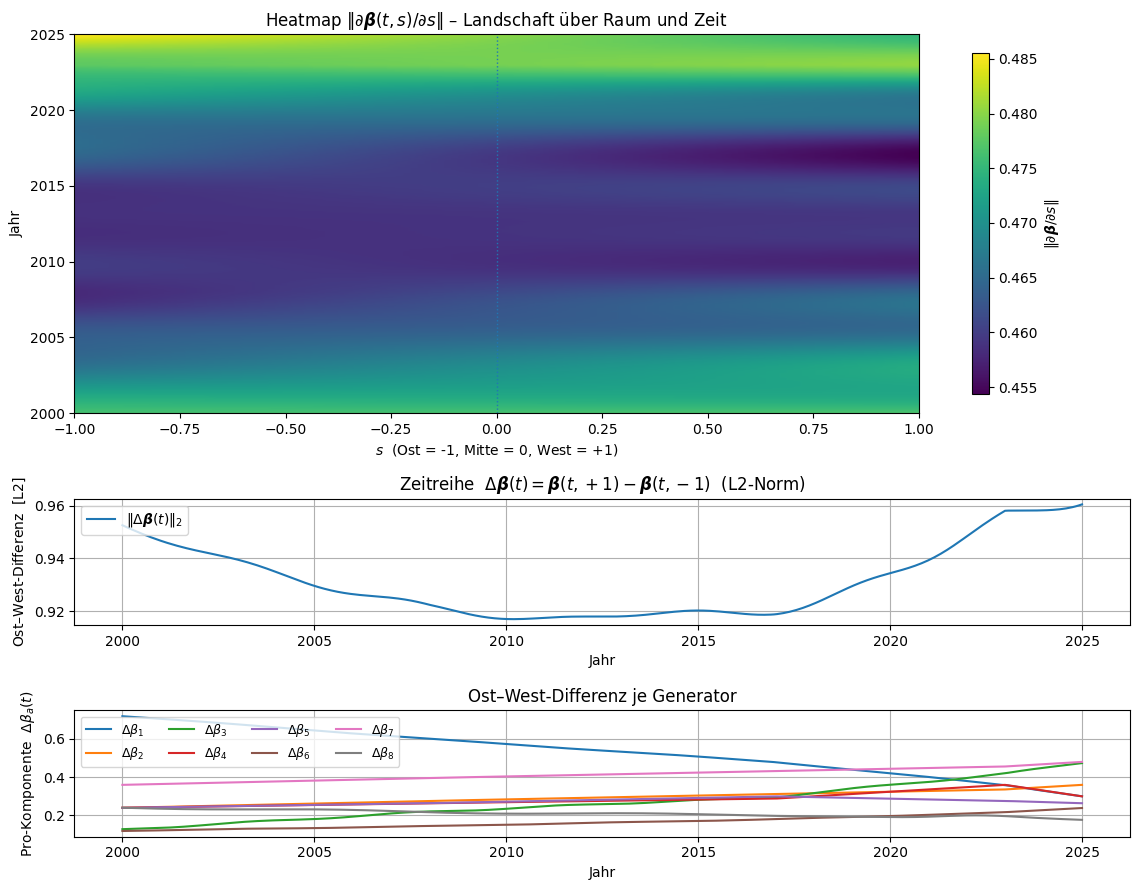

In [ ]:
# ==== ADD-ON: Δβ(t,s) – Heatmap & Ost–West-Differenzen =======================
# Voraussetzungen aus dem Hauptprogramm:
# - f_components(t: float) -> np.ndarray shape (8,)
# - a0_components(t: float) -> np.ndarray shape (8,)
# - u_of_s(s: float) -> float
# - v_of_s(s: float) -> float   # oder v_of_s(s, eta=...) – dann ggf. Wrapper bauen

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Effektive Kontrollparameter β_a(t,s)
# ------------------------------------------------------------
def beta_components(t: float, s: float, g0: float = 0.5, g1: float = 1.0) -> np.ndarray:
    """
    β_a(t,s) = g1 * u(s) * f_a(t) + g0 * v(s) * a0_a(t)
    Gibt Vektor (8,) zurück.
    """
    fa = f_components(t)            # (8,)
    a0 = a0_components(t)           # (8,)
    us = float(u_of_s(s))
    vs = float(v_of_s(s))
    return g1 * us * fa + g0 * vs * a0

def beta_norm_l2(t: float, s: float, g0: float = 0.5, g1: float = 1.0) -> float:
    b = beta_components(t, s, g0=g0, g1=g1)
    return float(np.linalg.norm(b))

# ------------------------------------------------------------
# 2) Räumliche Steilheit || ∂β/∂s || (numerisch)
# ------------------------------------------------------------
def beta_slope_norm_l2(t: float, s: float, g0: float = 0.5, g1: float = 1.0, ds: float = 1e-3) -> float:
    b_plus  = beta_components(t, s + ds, g0=g0, g1=g1)
    b_minus = beta_components(t, s - ds, g0=g0, g1=g1)
    db_ds   = (b_plus - b_minus) / (2.0 * ds)   # (8,)
    return float(np.linalg.norm(db_ds))

# ------------------------------------------------------------
# 3) Ost–West-Differenzen Δβ(t) und pro Generator
# ------------------------------------------------------------
def delta_beta_components_ow(t: float, g0: float = 0.5, g1: float = 1.0) -> np.ndarray:
    """
    Δβ_a(t) = β_a(t, +1) - β_a(t, -1)
    """
    bW = beta_components(t, +1.0, g0=g0, g1=g1)
    bE = beta_components(t, -1.0, g0=g0, g1=g1)
    return bW - bE   # (8,)

def delta_beta_norm_l2_ow(t: float, g0: float = 0.5, g1: float = 1.0) -> float:
    d = delta_beta_components_ow(t, g0=g0, g1=g1)
    return float(np.linalg.norm(d))

# ------------------------------------------------------------
# 4) Hauptplotter
# ------------------------------------------------------------
def plot_beta_difference_landscape(
    t_min=2000.0, t_max=2025.0, n_t=300,
    s_min=-1.0, s_max=+1.0, n_s=121,
    g0=0.5, g1=1.0,
    heatmap_mode="slope",   # "slope" -> ||∂β/∂s|| ; "delta" -> ||β(t,+1)-β(t,-1)|| als konst. Spalte
    show_per_generator=True
):
    """
    Erstellt:
      - links: Heatmap (||∂β/∂s|| über (t,s)) ODER konstante Δβ(t) über s (wenn heatmap_mode="delta")
      - rechts oben: Δβ_L2(t) (Ost–West)
      - rechts unten (optional): Δβ_a(t) je Generator a=1..8
    """
    t_grid = np.linspace(t_min, t_max, n_t)
    s_grid = np.linspace(s_min, s_max, n_s)

    # Heatmap vorbereiten
    H = np.zeros((n_t, n_s), dtype=float)

    if heatmap_mode == "slope":
        # numerische räumliche Steilheit
        for i, tt in enumerate(t_grid):
            for j, ss in enumerate(s_grid):
                H[i, j] = beta_slope_norm_l2(tt, ss, g0=g0, g1=g1)
        heat_title = r"Heatmap $\|\partial \boldsymbol{\beta}(t,s)/\partial s\|$"
        cbar_label = r"$\|\partial \boldsymbol{\beta}/\partial s\|$"
    elif heatmap_mode == "delta":
        # konstante Spalten mit ||β(t,+1)-β(t,-1)|| (zur direkten Ost–West-Betrachtung)
        for i, tt in enumerate(t_grid):
            H[i, :] = delta_beta_norm_l2_ow(tt, g0=g0, g1=g1)
        heat_title = r"Heatmap $\|\boldsymbol{\beta}(t,+1)-\boldsymbol{\beta}(t,-1)\|$"
        cbar_label = r"$\|\Delta \boldsymbol{\beta}(t)\|_{2}$"
    else:
        raise ValueError("heatmap_mode muss 'slope' oder 'delta' sein.")

    # Δβ_L2(t)
    dL2 = np.array([delta_beta_norm_l2_ow(tt, g0=g0, g1=g1) for tt in t_grid])

    # Δβ_a(t) pro Generator
    if show_per_generator:
        dA = np.vstack([delta_beta_components_ow(tt, g0=g0, g1=g1) for tt in t_grid])  # (n_t, 8)

    # ---- Plotlayout: 1 große Heatmap + 1-2 Panels darunter (untereinander) ----
    fig = plt.figure(figsize=(11.5, 9.0))
    gs = fig.add_gridspec(nrows=3 if show_per_generator else 2, ncols=1, height_ratios=[3, 1, 1] if show_per_generator else [3, 1])

    # (1) Heatmap
    ax0 = fig.add_subplot(gs[0, 0])
    extent = [s_min, s_max, t_min, t_max]
    im = ax0.imshow(H, origin='lower', extent=extent, aspect='auto')
    ax0.set_xlabel(r"$s$  (Ost = -1, Mitte = 0, West = +1)")
    ax0.set_ylabel("Jahr")
    ax0.set_title(heat_title + " – Landschaft über Raum und Zeit")
    cbar = fig.colorbar(im, ax=ax0, shrink=0.90)
    cbar.set_label(cbar_label)
    ax0.axvline(0.0, linestyle=":", linewidth=1.0)   # Mitte-Markierung

    # (2) Δβ_L2(t)
    ax1 = fig.add_subplot(gs[1, 0], sharex=None)
    ax1.plot(t_grid, dL2, label=r"$\|\Delta \boldsymbol{\beta}(t)\|_{2}$")
    ax1.set_xlabel("Jahr"); ax1.set_ylabel(r"Ost–West-Differenz  $[\mathrm{L2}]$")
    ax1.set_title(r"Zeitreihe  $\Delta \boldsymbol{\beta}(t)=\boldsymbol{\beta}(t,+1)-\boldsymbol{\beta}(t,-1)$  (L2-Norm)")
    ax1.grid(True); ax1.legend(loc="upper left")

    # (3) Δβ_a(t) pro Generator (optional)
    if show_per_generator:
        ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)
        labels = [r"$\Delta\beta_1$",
                  r"$\Delta\beta_2$",
                  r"$\Delta\beta_3$",
                  r"$\Delta\beta_4$",
                  r"$\Delta\beta_5$",
                  r"$\Delta\beta_6$",
                  r"$\Delta\beta_7$",
                  r"$\Delta\beta_8$"]
        for a in range(8):
            ax2.plot(t_grid, dA[:, a], label=labels[a])
        ax2.set_xlabel("Jahr"); ax2.set_ylabel(r"Pro-Komponente  $\Delta\beta_a(t)$")
        ax2.set_title("Ost–West-Differenz je Generator")
        ax2.grid(True); ax2.legend(ncol=4, fontsize=9, loc="upper left")

    plt.tight_layout()
    plt.show()

# ------------------ Beispielaufrufe ------------------
# 1) Räumliche Steilheit (zeigt, WO das Feld räumlich auseinanderläuft)
plot_beta_difference_landscape(heatmap_mode="slope", show_per_generator=True)

# 2) Reine Ost–West-Differenz als Heatmap (jede Spalte gleich: zur direkten Δβ(t)-Betrachtung)
# plot_beta_difference_landscape(heatmap_mode="delta", show_per_generator=False)


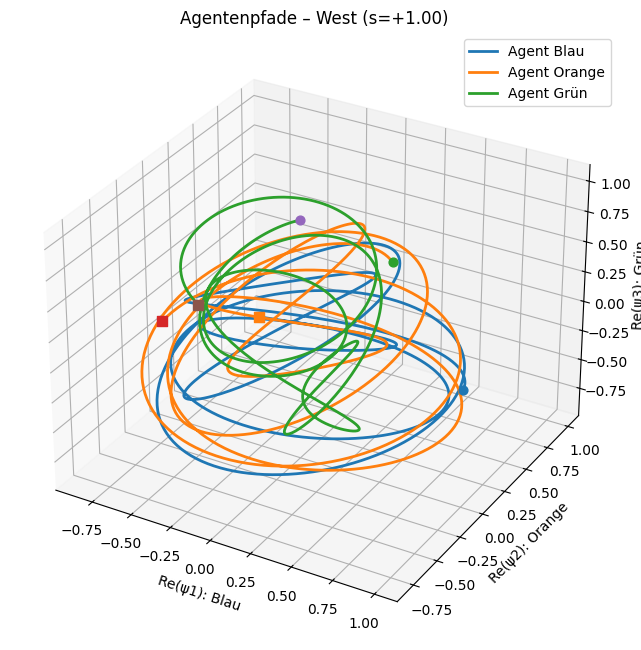

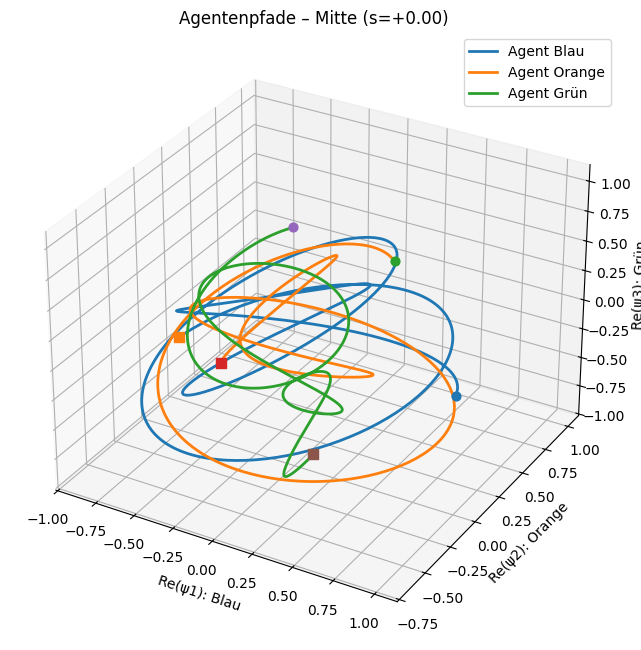

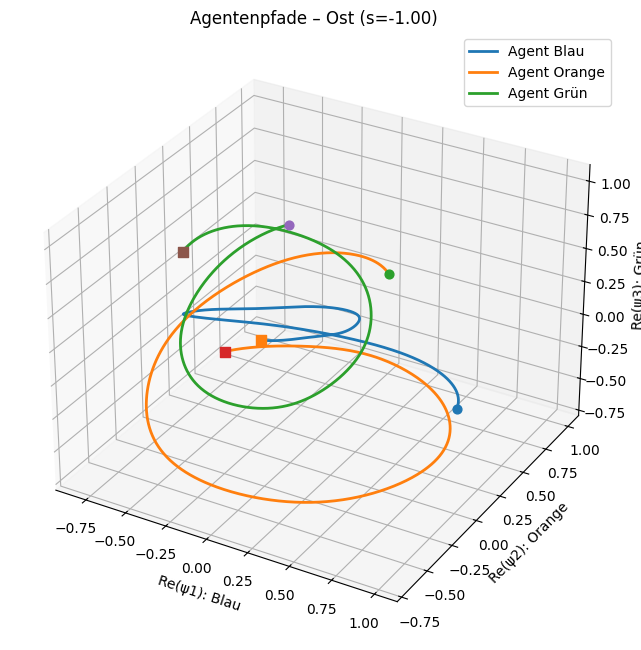

In [2]:
# ==== ADD-ON 3A: Pfad-Manager (berechnen, global speichern) + 3D-Plot ================
# Voraussetzungen aus Hauptprogramm:
# - evolve_state(psi0, s, g0, g1, t0, t1, n_eval)
# - normalize_path(P)
# - (optional) globale g0/g1; sonst hier Parameter setzen

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# Globale Speicherstruktur für Pfade (pro Region)
try:
    PATHS
except NameError:
    PATHS = {}   # keys: -1.0 (Ost), 0.0 (Mitte), +1.0 (West)

# Falls nicht vorhanden, hier die Startzustände:
try:
    psiA0; psiB0; psiC0
except NameError:
    psiA0 = np.array([1,0,0], complex)  # Blau
    psiB0 = np.array([0,1,0], complex)  # Orange
    psiC0 = np.array([0,0,1], complex)  # Grün

def _region_name(s_value):
    return "Ost" if s_value < -0.5 else ("West" if s_value > 0.5 else "Mitte")

def compute_paths_for_s(s_value: float,
                        g0: float = 0.5, g1: float = 1.0,
                        t0: float = 2000.0, t1: float = 2025.0, n_eval: int = 600,
                        store_last_globals: bool = True):
    """Berechnet Pfade für s und speichert sie global in PATHS[s].
       Zusätzlich (optional) werden t_eval, pathA, pathB, pathC als globale Variablen gesetzt."""
    t_eval, pA = evolve_state(psiA0, s_value, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    _,      pB = evolve_state(psiB0, s_value, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    _,      pC = evolve_state(psiC0, s_value, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    pA = normalize_path(pA); pB = normalize_path(pB); pC = normalize_path(pC)
    PATHS[float(s_value)] = (t_eval, pA, pB, pC)
    if store_last_globals:
        globals()['t_eval'] = t_eval
        globals()['pathA']  = pA
        globals()['pathB']  = pB
        globals()['pathC']  = pC
    return PATHS[float(s_value)]

def compute_all_paths(g0: float = 0.5, g1: float = 1.0,
                      t0: float = 2000.0, t1: float = 2025.0, n_eval: int = 600,
                      store_last_globals: bool = True):
    """Bequem alle drei Regionen vorrechnen und speichern."""
    for s in (-1.0, 0.0, +1.0):
        compute_paths_for_s(s, g0=g0, g1=g1, t0=t0, t1=t1, n_eval=n_eval,
                            store_last_globals=store_last_globals)
    return PATHS

def get_paths(s_value: float):
    """Liefert gespeicherte Pfade für s. Fehler, wenn nicht vorhanden."""
    key = float(s_value)
    if key not in PATHS:
        raise RuntimeError(f"Keine Pfade für s={s_value:+.1f} gefunden. "
                           f"Bitte compute_paths_for_s({s_value:+.1f}) zuerst aufrufen.")
    return PATHS[key]

def plot_agent_paths_3d(s_value, title_prefix="Agentenpfade"):
    """3D-Pfadplot für zuvor gespeicherte Pfade von s. Rechnet NICHT neu."""
    t_eval, pathA, pathB, pathC = get_paths(s_value)

    fig = plt.figure(figsize=(8.2,6.6))
    ax = fig.add_subplot(111, projection='3d')

    for path, lab in [(pathA, 'Agent Blau'), (pathB, 'Agent Orange'), (pathC, 'Agent Grün')]:
        X, Y, Z = path.real.T
        ax.plot(X, Y, Z, lw=2, label=lab)
        ax.scatter(X[0],  Y[0],  Z[0],  s=40, marker='o')  # Start
        ax.scatter(X[-1], Y[-1], Z[-1], s=60, marker='s')  # Ende

    ax.set_xlabel('Re(ψ1): Blau')
    ax.set_ylabel('Re(ψ2): Orange')
    ax.set_zlabel('Re(ψ3): Grün')
    region = _region_name(s_value)
    ax.set_title(f"{title_prefix} – {region} (s={s_value:+.2f})")
    ax.legend()
    plt.tight_layout(); plt.show()

# --- Beispiel ---
compute_paths_for_s(+1.0)     # West rechnen & speichern
plot_agent_paths_3d(+1.0)     # West-Pfade plotten (aus Speicher)
compute_paths_for_s(0.0)      # Mitte rechnen & speichern
plot_agent_paths_3d(0.0)      # Mitte-Pfade plotten (aus Speicher)
compute_paths_for_s(-1.0)     # Ost rechnen & speichern
plot_agent_paths_3d(-1.0)     # Ost-Pfade plotten (aus Speicher)
# compute_all_paths()         # Ost/Mitte/West vorberechnen


In [ ]:
# ========================= QSD Add-on (robust & kompatibel) =========================
# - nutzt Objekte aus dem Hauptprogramm, überschreibt sie NICHT, falls vorhanden
# - ergänzt nichtlineares v(s) (Ost-Peak-Blend)
# - macht H_of_t_s signatur-robust: (t,s) ODER (t,s,g0,g1)
# - bietet evolve_state_compat(...) als sichere Aufruffront
# - berechnet Pfade für s ∈ {-1,0,+1} und plottet Analysen + Kurzreports
# - nur matplotlib, keine festen Farben

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import pandas as pd

# ---------- 0) f_a(t) (nur falls im Hauptprogramm NICHT vorhanden) ----------
try:
    f_components
except NameError:
    years = np.array([2000, 2008, 2017, 2023, 2025], dtype=float)
    f1_vals = np.array([0.6, 0.5, 0.4, 0.3, 0.25], dtype=float)
    f2_vals = np.array([0.2, 0.23, 0.26, 0.28, 0.30], dtype=float)
    f3_vals = np.array([0.1, 0.18, 0.25, 0.35, 0.40], dtype=float)
    f4_vals = np.array([0.2, 0.22, 0.24, 0.30, 0.25], dtype=float)
    f5_vals = np.array([0.2, 0.22, 0.25, 0.23, 0.22], dtype=float)
    f6_vals = np.array([0.1, 0.12, 0.15, 0.18, 0.20], dtype=float)
    f7_vals = np.array([0.3, 0.33, 0.36, 0.38, 0.40], dtype=float)
    f8_vals = np.array([0.2, 0.18, 0.17, 0.16, 0.15], dtype=float)
    _fns = [None] + [interp1d(years, arr, kind='linear', fill_value='extrapolate')
                     for arr in [f1_vals,f2_vals,f3_vals,f4_vals,f5_vals,f6_vals,f7_vals,f8_vals]]
    def f_components(t: float) -> np.ndarray:
        return np.array([float(_fns[i](t)) for i in range(1,9)], dtype=float)

# ---------- 1) SU(3)-Generatoren (nur falls NICHT vorhanden) ----------
try:
    generators
except NameError:
    L1 = np.array([[0,1,0],[1,0,0],[0,0,0]], complex)
    L2 = np.array([[0,-1j,0],[1j,0,0],[0,0,0]], complex)
    L3 = np.array([[1,0,0],[0,-1,0],[0,0,0]], complex)
    L4 = np.array([[0,0,1],[0,0,0],[1,0,0]], complex)
    L5 = np.array([[0,0,-1j],[0,0,0],[1j,0,0]], complex)
    L6 = np.array([[0,0,0],[0,0,1],[0,1,0]], complex)
    L7 = np.array([[0,0,0],[0,0,-1j],[0,1j,0]], complex)
    L8 = (1/np.sqrt(3)) * np.diag([1,1,-2])
    generators = [L1,L2,L3,L4,L5,L6,L7,L8]

# ---------- 2) A0-Builder (nur falls NICHT vorhanden) ----------
try:
    a0_components
except NameError:
    def _trend_linear(t, a=0.0, b=0.0, t_ref=2012.5): return a + b*(t - t_ref)
    def _trend_sigmoid(t, amp=0.0, t0=2012.5, k=0.6): return amp * (2/(1+np.exp(-k*(t - t0))) - 1)
    def _cycle(t, amp=0.0, period=8.0, phase=0.0):   return amp * np.sin(2*np.pi*(t/period) + phase)
    def _pulse_gauss(t, amp=0.0, t0=2020.0, sigma=1.0): return amp * np.exp(-0.5*((t - t0)/sigma)**2)

    def _compose_a0(t, parts):
        y = np.zeros_like(t, dtype=float)
        if parts.get('linear'):  y += _trend_linear(t, **parts['linear'])
        if parts.get('sigmoid'): y += _trend_sigmoid(t, **parts['sigmoid'])
        for cyc in parts.get('cycles', []): y += _cycle(t, **cyc)
        for pls in parts.get('pulses', []): y += _pulse_gauss(t, **pls)
        return y

    def _orthogonalize_against(f_fn, a0_array, t_grid):
        f_vec = np.array([float(f_fn(t)) for t in t_grid])
        a_vec = a0_array.copy()
        denom = float(np.dot(f_vec, f_vec))
        if denom < 1e-12: return a_vec
        proj = float(np.dot(a_vec, f_vec)) / denom
        return a_vec - proj * f_vec

    A0_CONFIG = {
        8: dict(parts=dict(
                linear={'a':0.0, 'b':-0.004},
                sigmoid={'amp':0.05, 't0':2010.0, 'k':0.35},
                cycles=[{'amp':0.03, 'period':8.0, 'phase':0.3}],
                pulses=[{'amp':+0.05, 't0':2020.5, 'sigma':0.9},
                        {'amp':-0.03, 't0':2022.3, 'sigma':0.7}]),
           scale=1.0, orthogonalize_against_f=1, f_index=1),
        3: dict(parts=dict(
                linear={'a':0.0, 'b':+0.003},
                cycles=[{'amp':0.025, 'period':4.0, 'phase':-0.6}],
                pulses=[{'amp':+0.03, 't0':2016.0, 'sigma':1.0}]),
           scale=1.0, orthogonalize_against_f=1, f_index=3),
        1: dict(parts=dict(cycles=[{'amp':0.010, 'period':6.0, 'phase':0.0}]),
           scale=1.0, orthogonalize_against_f=0),
        6: dict(parts=dict(cycles=[{'amp':0.008, 'period':5.0, 'phase':1.2}]),
           scale=1.0, orthogonalize_against_f=0),
    }

    def make_a0_model(config=A0_CONFIG, t_min=2000.0, t_max=2025.0, n_fit=600):
        t_grid = np.linspace(t_min, t_max, n_fit)
        a0_time_series = {a: np.zeros_like(t_grid, dtype=float) for a in range(1,9)}
        for a, spec in config.items():
            parts = spec.get('parts', {})
            series = _compose_a0(t_grid, parts) * float(spec.get('scale', 1.0))
            if spec.get('orthogonalize_against_f', 0):
                def _f_fn(tt, idx=int(spec.get('f_index', a))):
                    return f_components(tt)[idx-1]
                series = _orthogonalize_against(lambda tt: _f_fn(tt), series, t_grid)
            a0_time_series[a] = series
        a0_funcs = []
        for a in range(1,9):
            fn = interp1d(t_grid, a0_time_series[a], kind='linear', fill_value='extrapolate')
            a0_funcs.append(fn)
        return a0_funcs

    a0_1, a0_2, a0_3, a0_4, a0_5, a0_6, a0_7, a0_8 = make_a0_model()

    def a0_components(t: float) -> np.ndarray:
        return np.array([float(fn(t)) for fn in [a0_1,a0_2,a0_3,a0_4,a0_5,a0_6,a0_7,a0_8]], dtype=float)

# ---------- 3) Profile u(s), v(s) – nichtlinear v(s) (nur falls NICHT vorhanden) ----------
try:
    u_of_s
except NameError:
    alpha_u = 0.6   # stärkere Struktur-Steigung (kannst du anpassen)
    def u_of_s(s: float) -> float:
        return 1.0 + alpha_u * s

try:
    v_of_s
except NameError:
    alpha_v = 0.50   # lineare Komponente v
    base_v  = 1.50   # Ost-Peak Basis
    k_v     = 0.40   # Krümmung
    eta_v   = 0.50   # Blend: 0 linear .. 1 Ost-Peak

    def _v_linear(s: float) -> float:
        return 1.0 + alpha_v * s

    def _v_local_east(s: float) -> float:
        return base_v - k_v*(s + 1.0)**2

    def v_of_s(s: float, eta: float = eta_v) -> float:
        return (1.0 - eta)*_v_linear(s) + eta*_v_local_east(s)

# ---------- 4) A1, A0 ----------
def A1_of_t_s(t: float, s: float) -> np.ndarray:
    A = np.zeros((3,3), dtype=complex); fa=f_components(t); us=u_of_s(s)
    for a in range(8): A += us * fa[a] * generators[a]
    return A

def A0_of_t_s(t: float, s: float) -> np.ndarray:
    A = np.zeros((3,3), dtype=complex); ca=a0_components(t); vs=v_of_s(s)
    for a in range(8): A += vs * ca[a] * generators[a]
    return A

# ---------- 5) Hamilton H(t,s): signatur-ROBUST ----------
# Falls g0,g1 global gesetzt sind, nutzen; sonst Default.
g0 = globals().get("g0", 0.5)
g1 = globals().get("g1", 1.0)

def _H_of_t_s_flexible(t, s, g0_in=None, g1_in=None):
    g0_eff = g0_in if g0_in is not None else globals().get("g0", g0)
    g1_eff = g1_in if g1_in is not None else globals().get("g1", g1)
    return g0_eff * A0_of_t_s(t, s) + g1_eff * A1_of_t_s(t, s)

# Wenn H_of_t_s existiert und nur (t,s) akzeptiert, ersetzen; wenn gar nicht existiert, setzen.
_need_patch = False
try:
    import inspect
    _old_sig = inspect.signature(H_of_t_s)  # evtl. aus Hauptprogramm
    _need_patch = len(_old_sig.parameters) == 2
except NameError:
    _need_patch = True

if _need_patch:
    H_of_t_s = _H_of_t_s_flexible
# Falls bereits eine 4-Parameter-Version existiert, belassen wir sie.

# ---------- 6) evolve_state: Kompatibilitäts-Hülle ----------
def evolve_state_fallback(psi0: np.ndarray, s: float,
                          t0: float = 2000.0, t1: float = 2025.0, n_eval: int = 600,
                          g0_in=None, g1_in=None):
    """Interner Fallback, nutzt flexibles H_of_t_s."""
    def schrodinger_rhs_local(t, psi_flat):
        psi = psi_flat[:3] + 1j*psi_flat[3:]
        H = H_of_t_s(t, s, g0_in, g1_in)
        dpsi = -1j * H @ psi
        return np.concatenate([dpsi.real, dpsi.imag])

    y0 = np.concatenate([psi0.real, psi0.imag])
    t_eval = np.linspace(t0, t1, n_eval)
    sol = solve_ivp(schrodinger_rhs_local, [t0, t1], y0,
                    t_eval=t_eval, rtol=1e-8, atol=1e-10, method='DOP853')
    psi_t = sol.y[:3, :] + 1j*sol.y[3:, :]
    norms = np.maximum(1e-14, np.linalg.norm(psi_t, axis=0, keepdims=True))
    psi_t = psi_t / norms
    return sol.t, psi_t.T

# Falls ein evolve_state aus dem Hauptprogramm existiert, verwenden – sonst Fallback.
def evolve_state_compat(psi0: np.ndarray, s: float,
                        t0: float = 2000.0, t1: float = 2025.0, n_eval: int = 600,
                        g0_in=None, g1_in=None):
    """Versucht vorhandenes evolve_state, sonst Fallback; akzeptiert optional g0,g1."""
    # 1) vorhandenes evolve_state ohne g0,g1?
    try:
        t, P = evolve_state(psi0, s, t0=t0, t1=t1, n_eval=n_eval)
        return t, P
    except TypeError:
        pass
    # 2) vorhandenes evolve_state mit g0,g1?
    try:
        t, P = evolve_state(psi0, s, g0=g0_in if g0_in is not None else g0,
                                      g1=g1_in if g1_in is not None else g1,
                                      t0=t0, t1=t1, n_eval=n_eval)
        return t, P
    except Exception:
        # 3) Fallback
        return evolve_state_fallback(psi0, s, t0=t0, t1=t1, n_eval=n_eval,
                                     g0_in=g0_in, g1_in=g1_in)

# ---------- 7) Pfade für Ost/Mitte/West ----------
try:
    psiA0; psiB0; psiC0
except NameError:
    psiA0 = np.array([1,0,0], complex)  # Blau
    psiB0 = np.array([0,1,0], complex)  # Orange
    psiC0 = np.array([0,0,1], complex)  # Grün

regions = [(-1.0, "Ost (s=-1)"), (0.0, "Mitte (s=0)"), (1.0, "West (s=+1)")]
PATHS = {}
for s_val, label in regions:
    t_eval, pathA = evolve_state_compat(psiA0, s_val)
    _,      pathB = evolve_state_compat(psiB0, s_val)
    _,      pathC = evolve_state_compat(psiC0, s_val)
    PATHS[s_val] = dict(t=t_eval, A=pathA, B=pathB, C=pathC, label=label)

# ---------- 8) Analyse-Hilfsfunktionen ----------
def normalize_path(P):
    n = np.maximum(1e-14, np.linalg.norm(P, axis=1, keepdims=True)); return P / n

def density_from_state(psi): return np.outer(psi, np.conjugate(psi))
def l1_coherence_from_rho(rho): return np.sum(np.abs(rho)) - np.sum(np.abs(np.diag(rho)))
def l1_coherence_from_amplitudes(psi):
    s = np.sum(np.abs(psi)); return s*s - 1.0

def mixture_density(ps_list, weights=None):
    K = len(ps_list);
    if weights is None: weights = np.ones(K) / K
    rho = np.zeros((3,3), dtype=complex)
    for w, psi in zip(weights, ps_list): rho += w * density_from_state(psi)
    return rho

def incremental_phase_series(path):
    phases = np.zeros(path.shape[0], float)
    for k in range(path.shape[0]-1):
        z = np.vdot(path[k], path[k+1])
        phases[k+1] = phases[k] + (np.angle(z) if np.abs(z) > 1e-14 else 0.0)
    return np.unwrap(phases)

def component_phases_unwrapped(path):
    ph = np.angle(path); return tuple(np.unwrap(ph[:,i]) for i in range(3))

def relative_phases_unwrapped(path, ref_index=0):
    ph = np.unwrap(np.angle(path), axis=0); ref = ph[:, ref_index][:, None]; rel = ph - ref
    return rel[:,1], rel[:,2]

def fubini_study_distance(psi, phi):
    m = np.clip(np.abs(np.vdot(psi, phi)), 0.0, 1.0); return np.arccos(m)

def cohesion_fs(paths_t):
    pairs = [(0,1),(0,2),(1,2)]; dsum = 0.0
    for i,j in pairs: dsum += fubini_study_distance(paths_t[i], paths_t[j])
    return 1.0 - (2.0/np.pi) * (dsum/len(pairs))

def cohesion_overlap(paths_t):
    pairs = [(0,1),(0,2),(1,2)]; s = 0.0
    for i,j in pairs: s += np.abs(np.vdot(paths_t[i], paths_t[j]))
    return s/len(pairs)

def entropy_bits(p):
    p = np.clip(p, 1e-15, 1.0); p /= np.sum(p)
    return -np.sum(p * (np.log(p)/np.log(2.0)))

def jensen_shannon_mi_bits(p, q):
    m = 0.5*(p+q); return entropy_bits(m) - 0.5*(entropy_bits(p)+entropy_bits(q))

def kron3(a, b, c): return np.kron(np.kron(a, b), c)
def density_from_pure_global(psi27): psi27 = psi27.reshape(-1, 1); return psi27 @ psi27.conj().T
def l1_coherence_global_from_abc(a, b, c):
    psi = kron3(a, b, c); rho = density_from_pure_global(psi); return l1_coherence_from_rho(rho)

# ---------- 9) Plots & Kurzreports pro Region ----------
for s_val, label in regions:
    rec = PATHS[s_val]
    t_eval = rec["t"]
    pathA = normalize_path(rec["A"]); pathB = normalize_path(rec["B"]); pathC = normalize_path(rec["C"])
    T = t_eval.shape[0]

    phiA = incremental_phase_series(pathA)
    phiB = incremental_phase_series(pathB)
    phiC = incremental_phase_series(pathC)

    A_bl, A_or, A_gr = component_phases_unwrapped(pathA)
    B_bl, B_or, B_gr = component_phases_unwrapped(pathB)
    C_bl, C_or, C_gr = component_phases_unwrapped(pathC)

    A_rel_or, A_rel_gr = relative_phases_unwrapped(pathA, ref_index=0)
    B_rel_or, B_rel_gr = relative_phases_unwrapped(pathB, ref_index=0)
    C_rel_or, C_rel_gr = relative_phases_unwrapped(pathC, ref_index=0)

    C_A_rho = np.empty(T); C_B_rho = np.empty(T); C_C_rho = np.empty(T)
    C_A_amp = np.empty(T); C_B_amp = np.empty(T); C_C_amp = np.empty(T)
    C_mix   = np.empty(T); C_global = np.empty(T)
    coh_fs_arr  = np.empty(T); coh_overlap_arr = np.empty(T)
    MI_AB = np.empty(T); MI_AC = np.empty(T); MI_BC = np.empty(T)

    for k in range(T):
        a = pathA[k]; b = pathB[k]; c = pathC[k]
        rhoA = density_from_state(a); rhoB = density_from_state(b); rhoC = density_from_state(c)
        C_A_rho[k] = l1_coherence_from_rho(rhoA)
        C_B_rho[k] = l1_coherence_from_rho(rhoB)
        C_C_rho[k] = l1_coherence_from_rho(rhoC)
        C_A_amp[k] = l1_coherence_from_amplitudes(a)
        C_B_amp[k] = l1_coherence_from_amplitudes(b)
        C_C_amp[k] = l1_coherence_from_amplitudes(c)
        rho_mix = mixture_density([a,b,c]); C_mix[k] = l1_coherence_from_rho(rho_mix)
        C_global[k] = l1_coherence_global_from_abc(a, b, c)
        coh_fs_arr[k] = cohesion_fs([a,b,c]); coh_overlap_arr[k] = cohesion_overlap([a,b,c])
        pA = np.abs(a)**2; pB = np.abs(b)**2; pC = np.abs(c)**2
        MI_AB[k] = jensen_shannon_mi_bits(pA, pB)
        MI_AC[k] = jensen_shannon_mi_bits(pA, pC)
        MI_BC[k] = jensen_shannon_mi_bits(pB, pC)

    # Referenzwerte (nur Anzeige)
    overlap_ref = 8.0/15.0
    fs_ref = 1.0 - (2.0/np.pi) * np.arccos(overlap_ref)

    # (a) Laufende Gesamtphasen
    plt.figure(figsize=(10,5))
    plt.plot(t_eval, phiA, label="Phase Agent A (Blau)")
    plt.plot(t_eval, phiB, label="Phase Agent B (Orange)")
    plt.plot(t_eval, phiC, label="Phase Agent C (Grün)")
    plt.xlabel("Jahr"); plt.ylabel("Phase (rad, entfaltet)")
    plt.title(f"Laufende Phasen – {label}")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # (b1) Komponentenphasen je Agent
    def plot_component_phases(t, ph_bl, ph_or, ph_gr, subtitle):
        plt.figure(figsize=(10,5))
        plt.plot(t, ph_bl, label="Komponente Blau")
        plt.plot(t, ph_or, label="Komponente Orange")
        plt.plot(t, ph_gr, label="Komponente Grün")
        plt.xlabel("Jahr"); plt.ylabel("Komponentenphase (rad, entfaltet)")
        plt.title(f"Komponentenphasen – {subtitle} – {label}")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    plot_component_phases(t_eval, A_bl, A_or, A_gr, "Agent A")
    plot_component_phases(t_eval, B_bl, B_or, B_gr, "Agent B")
    plot_component_phases(t_eval, C_bl, C_or, C_gr, "Agent C")

    # (b2) Relative Phasen je Agent (gauge-invariant)
    def plot_relative_phases(t, rel_or, rel_gr, subtitle):
        plt.figure(figsize=(10,5))
        plt.plot(t, rel_or, label="Orange – Blau")
        plt.plot(t, rel_gr, label="Grün – Blau")
        plt.xlabel("Jahr"); plt.ylabel("Relative Phase (rad, entfaltet)")
        plt.title(f"Relative Phasen – {subtitle} – {label}")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    plot_relative_phases(t_eval, A_rel_or, A_rel_gr, "Agent A")
    plot_relative_phases(t_eval, B_rel_or, B_rel_gr, "Agent B")
    plot_relative_phases(t_eval, C_rel_or, C_rel_gr, "Agent C")

    # (c) Kohärenz: Einzelagenten, Gesamtsystem (27×27) und Ensemble-Mix (3×3)
    plt.figure(figsize=(10,5))
    plt.plot(t_eval, C_A_rho, label="C_l1(A)")
    plt.plot(t_eval, C_B_rho, label="C_l1(B)")
    plt.plot(t_eval, C_C_rho, label="C_l1(C)")
    plt.plot(t_eval, C_global, label="C_l1(Gesamt, 27×27)")
    plt.plot(t_eval, C_mix,   label="C_l1(Ensemble-Mix 3×3)")
    plt.xlabel("Jahr"); plt.ylabel("l1-Kohärenz")
    plt.title(f"Kohärenz – {label}")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # (d) Kohärenz (Kontrollplot: geschlossene Formel für reine Zustände)
    plt.figure(figsize=(10,5))
    plt.plot(t_eval, C_A_amp, label="C_l1(A) – Formel")
    plt.plot(t_eval, C_B_amp, label="C_l1(B) – Formel")
    plt.plot(t_eval, C_C_amp, label="C_l1(C) – Formel")
    plt.xlabel("Jahr"); plt.ylabel("l1-Kohärenz")
    plt.title(f"Kohärenz (Formel, reine Zustände) – {label}")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # (e) Pairwise Jensen–Shannon MI (Bits)
    plt.figure(figsize=(10,5))
    plt.plot(t_eval, MI_AB, label="MI(A,B) [Bits]")
    plt.plot(t_eval, MI_AC, label="MI(A,C) [Bits]")
    plt.plot(t_eval, MI_BC, label="MI(B,C) [Bits]")
    plt.xlabel("Jahr"); plt.ylabel("Mutual Information [Bits]")
    plt.title(f"Jensen–Shannon MI – {label}")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # --- Kurzreport ---
    frag_index = 1.0 - cohesion_overlap([pathA[-1], pathB[-1], pathC[-1]])  # Beispiel am Ende
    df = pd.DataFrame({
        "Jahr": t_eval,
        "Phase_A": phiA, "Phase_B": phiB, "Phase_C": phiC,
        "C_l1_A_rho": C_A_rho, "C_l1_B_rho": C_B_rho, "C_l1_C_rho": C_C_rho,
        "C_l1_global_27x27": C_global,
        "C_l1_mix_ensemble": C_mix,
        "C_l1_A_form": C_A_amp, "C_l1_B_form": C_B_amp, "C_l1_C_form": C_C_amp,
        "Coh_FS_abs": coh_fs_arr, "Coh_Overlap_abs": coh_overlap_arr,
        "FS_Referenz": np.full(T, fs_ref),
        "Overlap_Referenz": np.full(T, overlap_ref),
        "MI_AB_bits": MI_AB, "MI_AC_bits": MI_AC, "MI_BC_bits": MI_BC
    })
    print(f"\n=== Kurzreport – {label} ===")
    print(df.head(8).to_string(index=False))

# ========================= Ende Add-on ==============================================


Output hidden; open in https://colab.research.google.com to view.

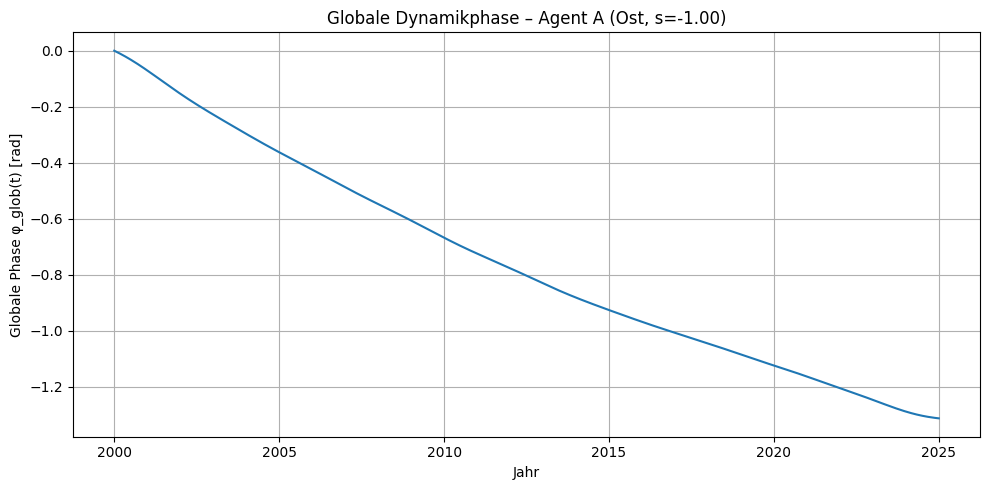

In [ ]:
# ==== Fix-Add-on: Globale Phase & Phasenabzug (robust) =====================

import numpy as np
import matplotlib.pyplot as plt

# 1) Hilfen: robustes PATHS holen + nächstliegenden Schlüssel finden
def _get_PATHS_dict():
    # Falls im Notebook nur 'PATHS' existiert, nimm es; sonst versuche 'paths';
    # wenn beides fehlt, rechne West/Mitte/Ost schnell nach.
    if 'PATHS' in globals():
        return globals()['PATHS']
    if 'paths' in globals():
        return globals()['paths']
    # Notfall: Pfade berechnen, falls evolve_state_compat verfügbar ist:
    if 'evolve_state_compat' in globals():
        psiA0 = globals().get('psiA0', np.array([1,0,0], complex))
        psiB0 = globals().get('psiB0', np.array([0,1,0], complex))
        psiC0 = globals().get('psiC0', np.array([0,0,1], complex))
        PATHS_local = {}
        for s_val, label in [(-1.0,"Ost (s=-1)"), (0.0,"Mitte (s=0)"), (1.0,"West (s=+1)")]:
            t_eval, pathA = evolve_state_compat(psiA0, s_val)
            _,      pathB = evolve_state_compat(psiB0, s_val)
            _,      pathC = evolve_state_compat(psiC0, s_val)
            PATHS_local[s_val] = dict(t=t_eval, A=pathA, B=pathB, C=pathC, label=label)
        globals()['PATHS'] = PATHS_local
        return PATHS_local
    raise RuntimeError("Weder PATHS/paths vorhanden noch evolve_state_compat verfügbar.")

def _nearest_key(d, s_query, tol=1e-6):
    keys = list(d.keys())
    # Falls exakt vorhanden:
    if s_query in d:
        return s_query
    # Nächstliegender Float-Key:
    k_best = min(keys, key=lambda k: abs(k - s_query))
    if abs(k_best - s_query) <= tol or True:
        return k_best
    raise KeyError(f"Kein passender Schlüssel für s={s_query}. Verfügbar: {keys}")

# 2) Globale Dynamikphase (inkrementell aus Pfad-Overlaps) und Phasenabzug
def compute_global_phase(t_eval, path):
    """
    Globale Dynamikphase φ_glob(t_k):
      φ_{k+1} = φ_k + arg(<ψ_k | ψ_{k+1}>),  mit Unwrap.
    Entspricht der globalen (Gauge-)Phase des zeitdiskreten Evolutionsoperators.
    """
    phi = np.zeros(len(t_eval), dtype=float)
    for k in range(len(t_eval)-1):
        z = np.vdot(path[k], path[k+1])
        phi[k+1] = phi[k] + (np.angle(z) if np.abs(z) > 1e-14 else 0.0)
    return np.unwrap(phi)

def remove_global_phase(path, phi_glob):
    """
    Entfernt die globale Phase: ψ̃_k = ψ_k * exp(-i φ_glob(t_k))
    """
    phase_factor = np.exp(-1j * phi_glob)
    return path * phase_factor[:, None]

# 3) Beispiel: Agent A (Ost)
PATHS_dict = _get_PATHS_dict()
s_key = _nearest_key(PATHS_dict, -1.0)  # robuster Zugriff auf Ost
rec = PATHS_dict[s_key]

t_eval = rec["t"]
pathA  = rec["A"]

phi_glob_A = compute_global_phase(t_eval, pathA)
psi_tilde_A = remove_global_phase(pathA, phi_glob_A)

# 4) Plot der globalen Phase
plt.figure(figsize=(10,5))
plt.plot(t_eval, phi_glob_A)
plt.xlabel("Jahr")
plt.ylabel("Globale Phase φ_glob(t) [rad]")
plt.title(f"Globale Dynamikphase – Agent A (Ost, s={s_key:+.2f})")
plt.grid(True); plt.tight_layout(); plt.show()

# (Optional) Kontrolle: Realteil-Komponenten nach Phasenabzug
# plt.figure(figsize=(10,5))
# plt.plot(t_eval, psi_tilde_A.real[:,0], label="Re ψ̃_b")
# plt.plot(t_eval, psi_tilde_A.real[:,1], label="Re ψ̃_o")
# plt.plot(t_eval, psi_tilde_A.real[:,2], label="Re ψ̃_g")
# plt.xlabel("Jahr"); plt.ylabel("Re(ψ̃)")
# plt.title("Agent A (Ost): Komponenten nach Globalphasen-Abzug")
# plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


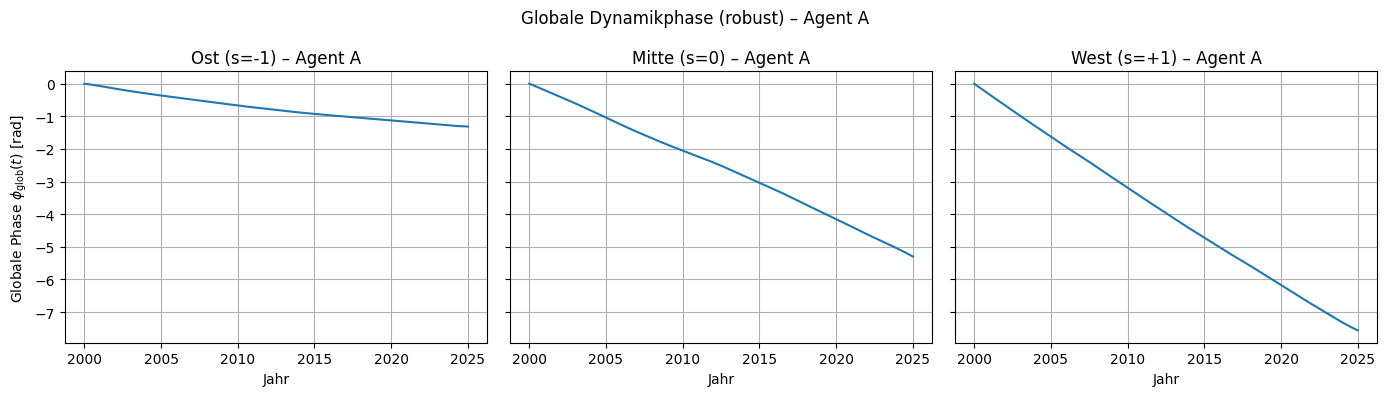

In [ ]:
# ==== ADD-ON: Globale Dynamikphase robust (kompatibel zu H(t,s) und H(t,s,g0,g1)) ====
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- kleine Utilities ---------------------------------------------------------------
def _get_globals_default(name, default):
    return globals().get(name, default)

def normalize_path(P):
    """Zeilenweise Normierung eines Pfades (T,3)."""
    n = np.maximum(1e-14, np.linalg.norm(P, axis=1, keepdims=True))
    return P / n

# Robuster Aufruf von H_of_t_s: akzeptiert H(t,s) oder H(t,s,g0,g1)
def _call_H(H_of_t_s, t, s):
    try:
        return H_of_t_s(t, s)
    except TypeError:
        g0 = _get_globals_default('g0', 0.5)
        g1 = _get_globals_default('g1', 1.0)
        return H_of_t_s(t, s, g0, g1)

# --- Pfade sicherstellen ------------------------------------------------------------
def evolve_state_compat(psi0, s, t0=2000.0, t1=2025.0, n_eval=600, g0_in=None, g1_in=None):
    """
    Ruft eine vorhandene evolve_state-Funktion auf, egal ob sie (psi0,s,...) oder (psi0,s,g0,g1,...) erwartet.
    Falls es keine gibt, wird ein lokaler Fallback-Integrator mit dem Hamiltonoperator verwendet.
    """
    # 1) Versuche eine vorhandene evolve_state zu nutzen
    _evo = globals().get('evolve_state', None)
    if callable(_evo):
        try:
            # Variante mit benannten g0/g1
            return _evo(psi0, s,
                        g0=_get_globals_default('g0', 0.5) if g0_in is None else g0_in,
                        g1=_get_globals_default('g1', 1.0) if g1_in is None else g1_in,
                        t0=t0, t1=t1, n_eval=n_eval)
        except TypeError:
            # Variante ohne g0/g1
            return _evo(psi0, s, t0=t0, t1=t1, n_eval=n_eval)

    # 2) Fallback: integriere i dψ/dt = H ψ mit lokalem RHS
    def _rhs(t, y):
        psi = y[:3] + 1j*y[3:]
        H = _call_H(globals()['H_of_t_s'], t, s)
        dpsi = -1j * H @ psi
        return np.concatenate([dpsi.real, dpsi.imag])

    y0 = np.concatenate([psi0.real, psi0.imag])
    t_eval = np.linspace(t0, t1, n_eval)
    sol = solve_ivp(_rhs, [t0, t1], y0, t_eval=t_eval, method='DOP853',
                    atol=1e-10, rtol=1e-8)
    psi_t = sol.y[:3, :] + 1j*sol.y[3:, :]
    psi_t = normalize_path(psi_t.T)  # (T,3)
    return sol.t, psi_t

def ensure_paths_for_regions(regions=(-1.0, 0.0, +1.0)):
    """
    Liefert ein Dict paths[s] = {'t', 'A','B','C','label'}.
    Nutzt vorhandenes `paths` falls möglich, sonst rechnet es neu.
    """
    out = {}
    has_paths = isinstance(globals().get('paths', None), dict)
    labels = { -1.0: "Ost (s=-1)", 0.0: "Mitte (s=0)", 1.0: "West (s=+1)" }

    # Startzustände (falls nicht vorhanden)
    psiA0 = _get_globals_default('psiA0', np.array([1,0,0], complex))
    psiB0 = _get_globals_default('psiB0', np.array([0,1,0], complex))
    psiC0 = _get_globals_default('psiC0', np.array([0,0,1], complex))

    for s in regions:
        if has_paths and s in globals()['paths']:
            rec = globals()['paths'][s]
            out[s] = {'t': rec['t'], 'A': normalize_path(rec['A']),
                      'B': normalize_path(rec['B']), 'C': normalize_path(rec['C']),
                      'label': rec.get('label', labels.get(s, f"s={s:+.2f}"))}
        else:
            tA, A = evolve_state_compat(psiA0, s)
            _,  B = evolve_state_compat(psiB0, s)
            _,  C = evolve_state_compat(psiC0, s)
            out[s] = {'t': tA, 'A': normalize_path(A),
                      'B': normalize_path(B), 'C': normalize_path(C),
                      'label': labels.get(s, f"s={s:+.2f}")}
    return out

# --- Globale Phase & Phasenabzug ----------------------------------------------------
def compute_global_phase(t_eval, path, H_of_t_s, s):
    """
    φ_glob(t_k) ≈ -∑_{m<k} 0.5*(E_m+E_{m+1}) Δt,   E(t)=⟨ψ|H|ψ⟩
    """
    E = np.empty_like(t_eval, dtype=float)
    for k, (t, psi) in enumerate(zip(t_eval, path)):
        H = _call_H(H_of_t_s, t, s)
        E[k] = float(np.real(np.vdot(psi, H @ psi)))

    phi = np.zeros_like(t_eval, dtype=float)
    if len(t_eval) > 1:
        dt = np.diff(t_eval)
        phi[1:] = -np.cumsum(0.5*(E[1:]+E[:-1]) * dt)
    return phi

def remove_global_phase(path, phi_glob):
    """ψ̃_k = e^{+i φ_glob(t_k)} ψ_k (gauge: globale Dynamikphase entfernt)."""
    return path * np.exp(1j*phi_glob)[:, None]

# --- Plots --------------------------------------------------------------------------
def plot_global_phase_all_regions(agent='A'):
    """
    Plottet φ_glob(t) für Agent {A|B|C} in Ost/Mitte/West.
    """
    if agent not in ('A','B','C'):
        raise ValueError("agent muss 'A', 'B' oder 'C' sein.")
    P = ensure_paths_for_regions(regions=(-1.0, 0.0, +1.0))

    fig, axes = plt.subplots(1, 3, figsize=(14,4), sharey=True)
    for ax, s in zip(axes, (-1.0, 0.0, +1.0)):
        rec = P[s]
        t = rec['t']; path = rec[agent]
        phi = compute_global_phase(t, path, globals()['H_of_t_s'], s)
        ax.plot(t, phi)
        ax.set_title(f"{rec['label']} – Agent {agent}")
        ax.set_xlabel("Jahr")
        ax.grid(True)
    axes[0].set_ylabel(r"Globale Phase $\phi_{\mathrm{glob}}(t)$ [rad]")
    fig.suptitle("Globale Dynamikphase (robust) – Agent {}".format(agent))
    plt.tight_layout(); plt.show()

# --- Beispiel: sofort plotten (Agent A) --------------------------------------------
plot_global_phase_all_regions('A')
# plot_global_phase_all_regions('B')
# plot_global_phase_all_regions('C')


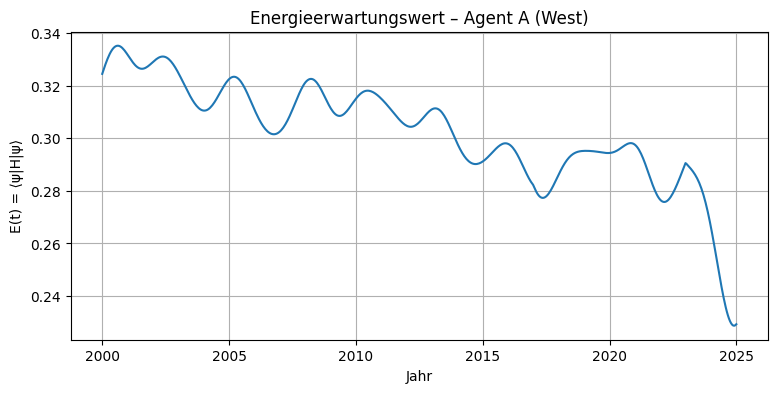

In [ ]:
def compute_energy_expectation(t_eval, path, H_of_t_s, s):
    E = np.empty_like(t_eval, dtype=float)
    for k, (t, psi) in enumerate(zip(t_eval, path)):
        H = _call_H(H_of_t_s, t, s)
        E[k] = np.real(np.vdot(psi, H @ psi))
    return E

# Beispiel:
s = +1.0  # Westen
P = ensure_paths_for_regions()
t = P[s]['t']; A = P[s]['A']
E = compute_energy_expectation(t, A, H_of_t_s, s)
plt.figure(figsize=(9,4))
plt.plot(t, E)
plt.title("Energieerwartungswert – Agent A (West)")
plt.xlabel("Jahr"); plt.ylabel("E(t) = ⟨ψ|H|ψ⟩")
plt.grid(True); plt.show()


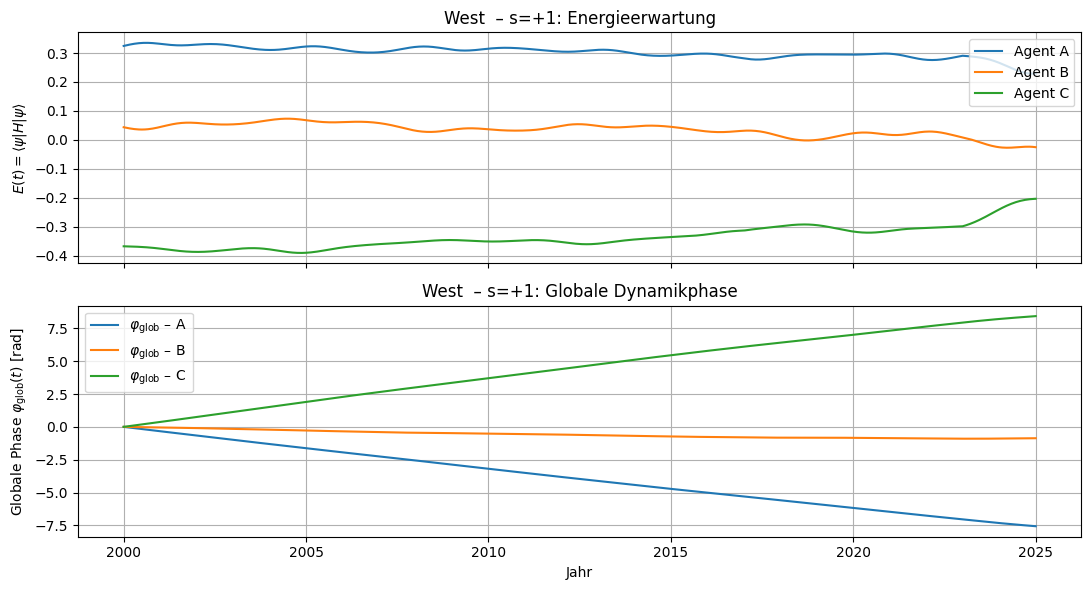

In [ ]:
# ==== ADD-ON: Energieerwartung & globale Phase für A,B,C in Ost/Mitte/West ====
# Voraussetzungen (werden – falls vorhanden – aus dem Hauptprogramm verwendet):
# - H_of_t_s(t, s)      oder H_of_t_s(t, s, g0, g1)
# - evolve_state(...)   (mit oder ohne g0/g1 als Keyword-Args)
# - psiA0, psiB0, psiC0 (Startzustände)
# - ggf. PATHS_REGISTRY  (aus früheren Add-ons); sonst rechnen wir Pfade neu
# ------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---- 1) Kompatibilitäts-Helfer -----------------------------------------------

def _call_H(H_of_t_s, t, s):
    """Robust: versuche H(t,s,g0,g1), sonst H(t,s)."""
    try:
        # greife ggf. auf globale g0/g1 zurück, wenn existent
        return H_of_t_s(t, s, g0, g1)  # noqa: F821 falls nicht vorhanden -> except
    except Exception:
        return H_of_t_s(t, s)

def _evolve_state_compat(psi0, s, t0=2000.0, t1=2025.0, n_eval=600):
    """Nutze vorhandenes evolve_state, egal ob es g0/g1 verlangt oder nicht.
       Fallback-Integrator, falls evolve_state nicht existiert."""
    # 1) benutze vorhandenes evolve_state
    try:
        evolve_state  # noqa: F821
        try:
            # Variante mit g0/g1
            t, P = evolve_state(psi0, s, g0=g0, g1=g1, t0=t0, t1=t1, n_eval=n_eval)  # noqa: F821
            return t, P
        except TypeError:
            # Variante ohne g0/g1
            t, P = evolve_state(psi0, s, t0=t0, t1=t1, n_eval=n_eval)  # noqa: F821
            return t, P
    except Exception:
        pass

    # 2) Fallback: baue H(t) und integriere i dψ/dt = H ψ
    def schrodinger_rhs(t, psi_flat):
        psi = psi_flat[:3] + 1j*psi_flat[3:]
        H   = _call_H(H_of_t_s, t, s)
        dpsi = -1j * (H @ psi)
        return np.concatenate([dpsi.real, dpsi.imag])

    y0 = np.concatenate([np.real(psi0), np.imag(psi0)])
    t_eval = np.linspace(t0, t1, n_eval)
    sol = solve_ivp(schrodinger_rhs, [t0, t1], y0,
                    t_eval=t_eval, rtol=1e-8, atol=1e-10, method="DOP853")
    psi_t = sol.y[:3,:].T + 1j*sol.y[3:,:].T
    # Numerisch normalisieren (Sicherheit)
    n = np.maximum(1e-14, np.linalg.norm(psi_t, axis=1, keepdims=True))
    psi_t = psi_t / n
    return sol.t, psi_t

def _ensure_starts():
    """Hole Startzustände aus dem Hauptprogramm oder setze Defaults."""
    try:
        return psiA0, psiB0, psiC0  # noqa: F821
    except Exception:
        A = np.array([1,0,0], complex)
        B = np.array([0,1,0], complex)
        C = np.array([0,0,1], complex)
        return A, B, C

# ---- 2) Pfade bereitstellen (Registry oder Neu-Berechnung) -------------------

def ensure_paths_for_regions(t0=2000.0, t1=2025.0, n_eval=600):
    """Liefert dict: {s:{'t', 'A','B','C','label'}} für s∈{-1,0,+1}."""
    # Falls bereits vorhanden (aus früheren Add-ons), direkt nutzen:
    try:
        reg = PATHS_REGISTRY  # noqa: F821
        # Minimal-Check:
        if all(s in reg for s in (-1.0, 0.0, +1.0)):
            return reg
    except Exception:
        pass

    A0, B0, C0 = _ensure_starts()
    regions = [(-1.0, "Ost (s=-1)"), (0.0, "Mitte (s=0)"), (+1.0, "West (s=+1)")]
    paths = {}
    for s_val, label in regions:
        t, A = _evolve_state_compat(A0, s_val, t0=t0, t1=t1, n_eval=n_eval)
        _, B = _evolve_state_compat(B0, s_val, t0=t0, t1=t1, n_eval=n_eval)
        _, C = _evolve_state_compat(C0, s_val, t0=t0, t1=t1, n_eval=n_eval)
        paths[s_val] = dict(t=t, A=A, B=B, C=C, label=label)

    # in Registry ablegen (optional)
    globals()["PATHS_REGISTRY"] = paths
    return paths

# ---- 3) E(t) und φ_glob(t) ---------------------------------------------------

def compute_energy_expectation(t_eval, path, H_of_t_s, s):
    """E(t)=<ψ|H|ψ> (rein reell)."""
    E = np.empty_like(t_eval, dtype=float)
    for k, (t, psi) in enumerate(zip(t_eval, path)):
        H = _call_H(H_of_t_s, t, s)
        E[k] = float(np.real(np.vdot(psi, H @ psi)))
    return E

def integrate_trapezoid(x, y):
    """∫ y dx, kumulativ (Trapezregel)."""
    acc = np.zeros_like(x, dtype=float)
    for i in range(1, len(x)):
        acc[i] = acc[i-1] + 0.5*(y[i] + y[i-1])*(x[i]-x[i-1])
    return acc

def compute_global_phase_from_energy(t_eval, E):
    """φ_glob(t) = -∫ E(τ) dτ."""
    return -integrate_trapezoid(t_eval, E)

# ---- 4) Plotter: pro Region alle drei Agenten --------------------------------

def plot_energy_and_global_phase_for_region(s_val, title_prefix=None):
    paths = ensure_paths_for_regions()
    rec = paths[s_val]
    t   = rec["t"]
    A,B,C = rec["A"], rec["B"], rec["C"]

    EA = compute_energy_expectation(t, A, H_of_t_s, s_val)
    EB = compute_energy_expectation(t, B, H_of_t_s, s_val)
    EC = compute_energy_expectation(t, C, H_of_t_s, s_val)

    phiA = compute_global_phase_from_energy(t, EA)
    phiB = compute_global_phase_from_energy(t, EB)
    phiC = compute_global_phase_from_energy(t, EC)

    ttl = (title_prefix or rec["label"]).replace("(s=", " – s=").replace(")", "")
    fig, axs = plt.subplots(2, 1, figsize=(11,6), sharex=True)

    # (oben) Energieerwartungswert
    axs[0].plot(t, EA, label="Agent A")
    axs[0].plot(t, EB, label="Agent B")
    axs[0].plot(t, EC, label="Agent C")
    axs[0].set_ylabel(r"$E(t)=\langle\psi|H|\psi\rangle$")
    axs[0].set_title(f"{ttl}: Energieerwartung")
    axs[0].grid(True); axs[0].legend()

    # (unten) Globale Phase
    axs[1].plot(t, phiA, label=r"$\varphi_{\mathrm{glob}}$ – A")
    axs[1].plot(t, phiB, label=r"$\varphi_{\mathrm{glob}}$ – B")
    axs[1].plot(t, phiC, label=r"$\varphi_{\mathrm{glob}}$ – C")
    axs[1].set_xlabel("Jahr")
    axs[1].set_ylabel(r"Globale Phase $\varphi_{\mathrm{glob}}(t)$ [rad]")
    axs[1].set_title(f"{ttl}: Globale Dynamikphase")
    axs[1].grid(True); axs[1].legend()

    plt.tight_layout(); plt.show()

def plot_energy_and_global_phase_all_regions():
    for s in (-1.0, 0.0, +1.0):
        plot_energy_and_global_phase_for_region(s)

# ---- 5) Beispielaufrufe -------------------------------------------------------
# (a) Ein Region-Plot:
plot_energy_and_global_phase_for_region(+1.0)   # West
# (b) Alle drei Regionen:
# plot_energy_and_global_phase_all_regions()


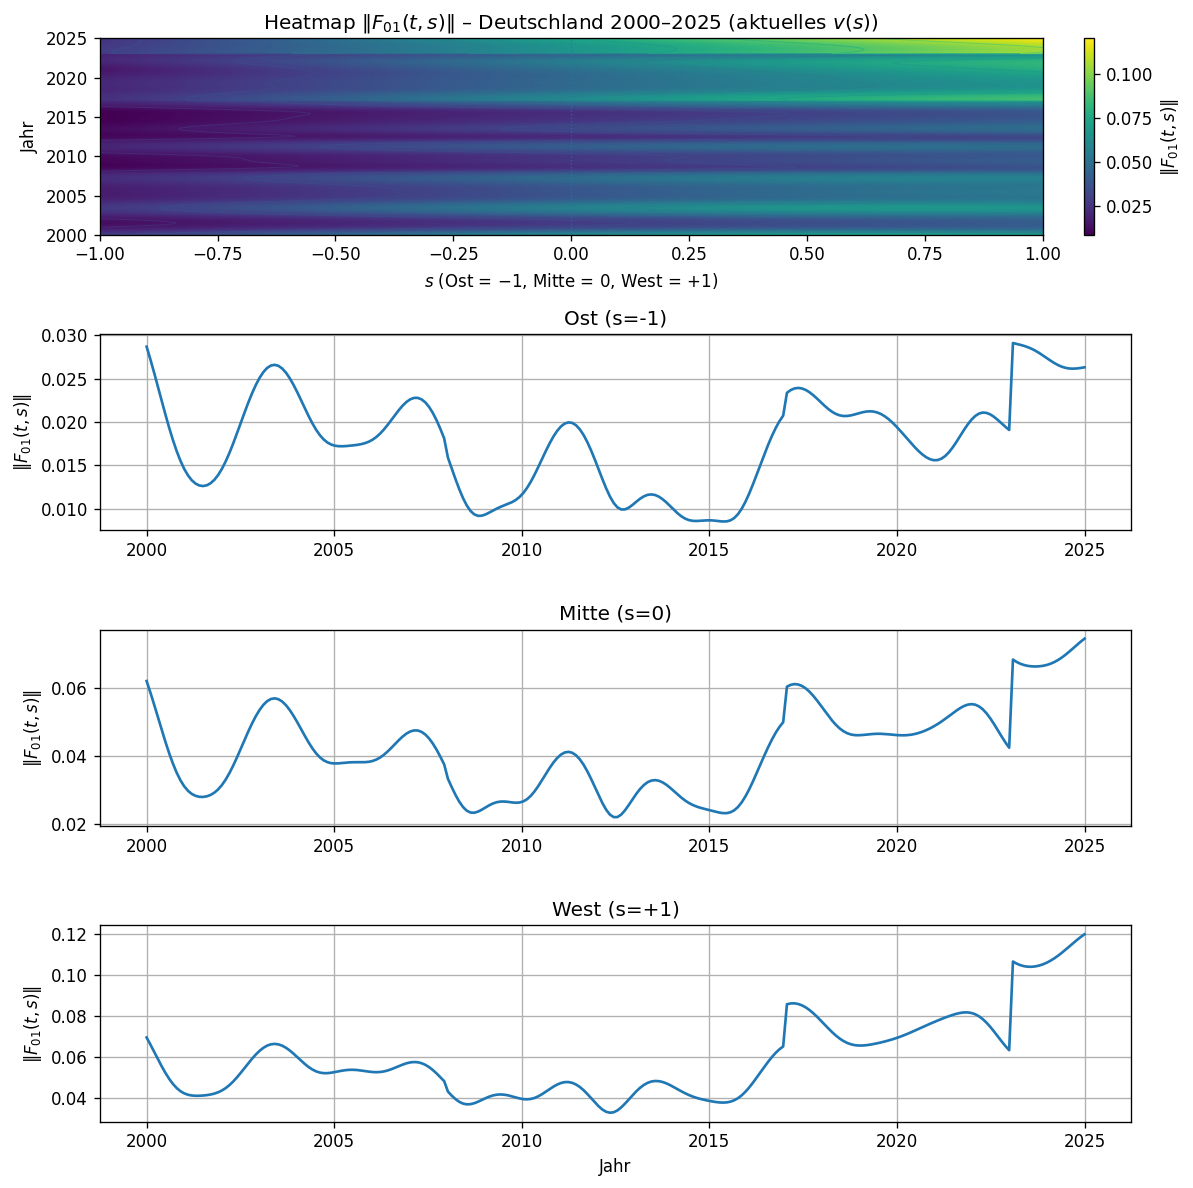

In [ ]:
# ==== ADD-ON: Feldtensor-Heatmap + Ost/Mitte/West-Zeitschnitte (vertikal) ============
# Voraussetzungen: f_components, a0_components, generators, u_of_s, v_of_s

import numpy as np
import matplotlib.pyplot as plt

def _comm(X, Y): return X @ Y - Y @ X

def _v_eval(s, eta_override):
    if eta_override is None:
        return float(v_of_s(s))
    try:
        return float(v_of_s(s, eta=eta_override))
    except TypeError:
        return float(v_of_s(s))

def _A1_of_t_s(t, s):
    fa = f_components(t); us = float(u_of_s(s))
    A  = np.zeros((3,3), dtype=complex)
    for a in range(8):
        A += us * fa[a] * generators[a]
    return A

def _A0_of_t_s(t, s, eta_override=None):
    ca = a0_components(t); vs = _v_eval(s, eta_override)
    A  = np.zeros((3,3), dtype=complex)
    for a in range(8):
        A += vs * ca[a] * generators[a]
    return A

def _dA1_dt(t, s, h=1e-3):
    return (_A1_of_t_s(t+h, s) - _A1_of_t_s(t-h, s)) / (2*h)

def _dA0_ds(t, s, eta_override=None, ds=1e-3):
    return (_A0_of_t_s(t, s+ds, eta_override) - _A0_of_t_s(t, s-ds, eta_override)) / (2*ds)

def _F01_of_t_s(t, s, g0=0.5, g1=1.0, eta_override=None):
    A1  = g1 * _A1_of_t_s(t, s)
    A0  = g0 * _A0_of_t_s(t, s, eta_override)
    dA1 = g1 * _dA1_dt(t, s)
    dA0 = g0 * _dA0_ds(t, s, eta_override)
    return dA1 - dA0 + _comm(A0, A1)

def _F_intensity(t, s, g0=0.5, g1=1.0, eta_override=None):
    F = _F01_of_t_s(t, s, g0=g0, g1=g1, eta_override=eta_override)
    return float(np.sqrt(np.trace(F.conj().T @ F).real))

def plot_fieldtensor_heatmap_vertical(
    t_min=2000.0, t_max=2025.0, n_t=250,
    s_min=-1.0,  s_max=+1.0,  n_s=141,
    g0=0.5, g1=1.0,
    eta=None,
    s_slices=(-1.0, 0.0, +1.0),
    with_contours=True,
    dpi=120,
):
    t_grid = np.linspace(t_min, t_max, n_t)
    s_grid = np.linspace(s_min, s_max, n_s)
    Fmap   = np.zeros((n_t, n_s), dtype=float)

    # Heatmap berechnen
    for i, t in enumerate(t_grid):
        for j, s in enumerate(s_grid):
            Fmap[i, j] = _F_intensity(t, s, g0=g0, g1=g1, eta_override=eta)

    # Zeitschnittdaten
    slices = {}
    for s_fix in s_slices:
        vals = np.array([_F_intensity(t, s_fix, g0=g0, g1=g1, eta_override=eta) for t in t_grid])
        slices[s_fix] = vals

    # --- Plotlayout: 1 Spalte, 4 Zeilen (Heatmap + 3 Linienplots)
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), dpi=dpi, sharex=False)

    # (1) Heatmap oben
    ax_hm = axes[0]
    extent = [s_grid.min(), s_grid.max(), t_grid.min(), t_grid.max()]
    im = ax_hm.imshow(Fmap, origin='lower', extent=extent, aspect='auto')
    cb = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
    cb.set_label(r"$\|F_{01}(t,s)\|$")
    if with_contours:
        ax_hm.contour(s_grid, t_grid, Fmap, levels=8, linewidths=0.6)
    for s_ref in s_slices:
        ax_hm.axvline(s_ref, linestyle=":", linewidth=0.8, alpha=0.7)
    subtitle = r"(aktuelles $v(s)$)" if eta is None else rf"(mit $\eta={eta:.2f}$)"
    ax_hm.set_title(r"Heatmap $\|F_{01}(t,s)\|$ – Deutschland 2000–2025 " + subtitle)
    ax_hm.set_xlabel(r"$s$ (Ost = −1, Mitte = 0, West = +1)")
    ax_hm.set_ylabel("Jahr")

    # (2–4) Zeitschnitte untereinander
    labels = { -1.0: "Ost (s=-1)", 0.0: "Mitte (s=0)", 1.0: "West (s=+1)" }
    for i, s_fix in enumerate(s_slices):
        ax = axes[i+1]
        ax.plot(t_grid, slices[s_fix], color="tab:blue", lw=1.6)
        ax.set_title(labels.get(s_fix, f"s={s_fix:+.2f}"))
        ax.set_ylabel(r"$\|F_{01}(t,s)\|$")
        ax.grid(True)
        if i == len(s_slices)-1:
            ax.set_xlabel("Jahr")

    plt.tight_layout()
    plt.show()

    #return {"t_grid": t_grid, "s_grid": s_grid, "Fmap": Fmap, "slices": slices}

# --- Beispielaufrufe:
plot_fieldtensor_heatmap_vertical()
# plot_fieldtensor_heatmap_vertical(eta=0.2)


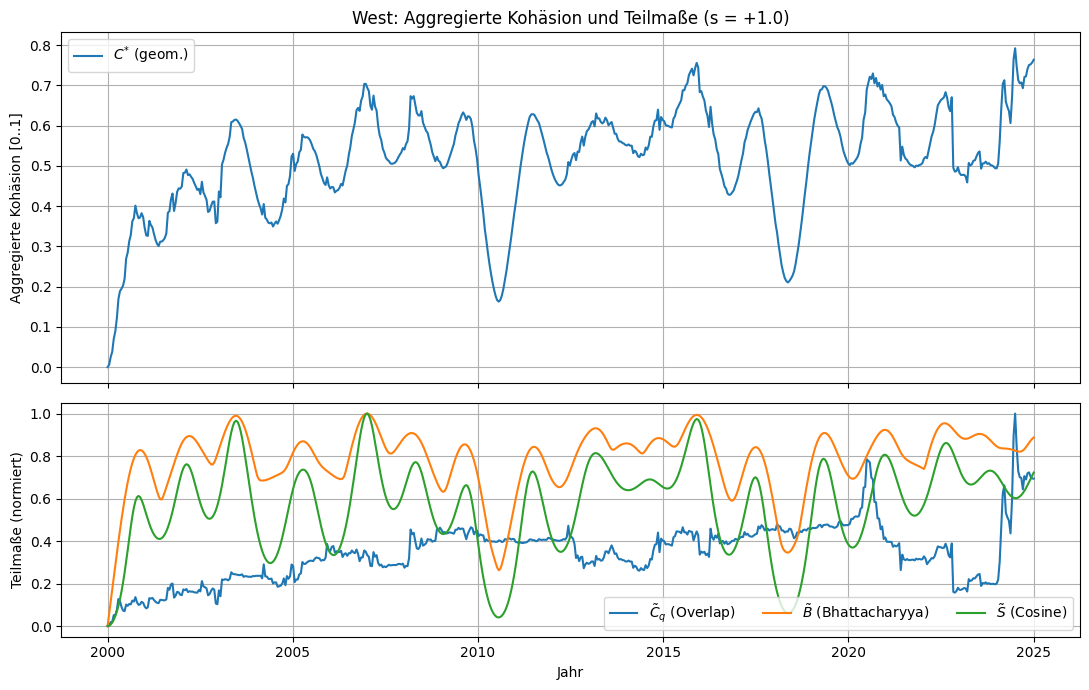

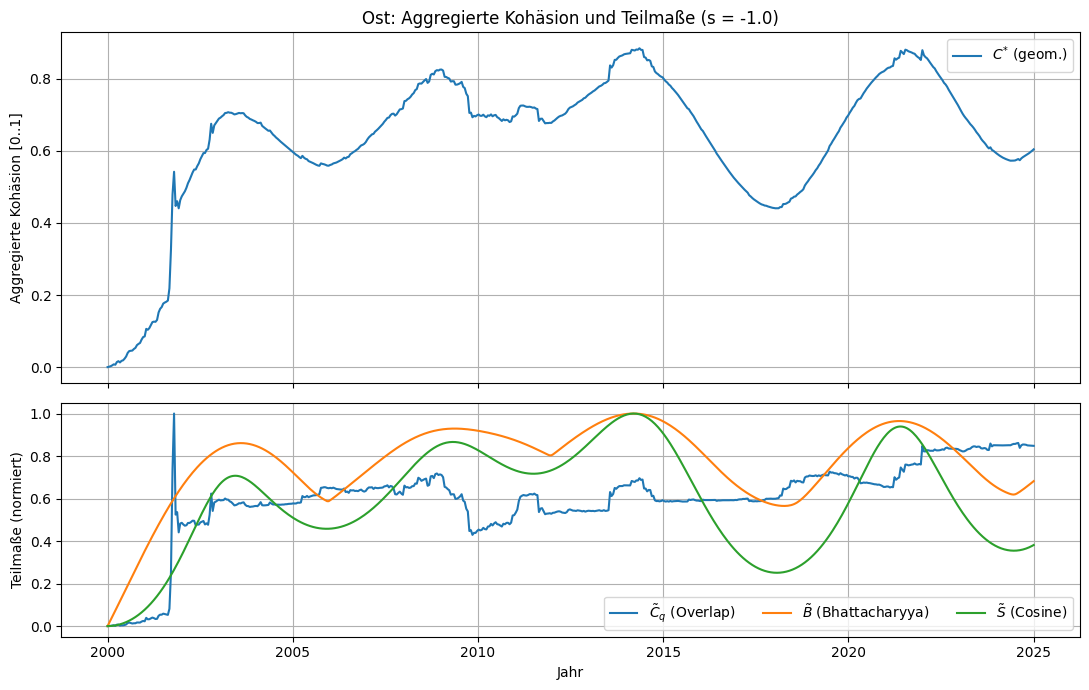

In [4]:
# ==== ADD-ON 4 (fix): Kohäsions-Plot NUR aus gespeicherten PATHS =====================
# Unterstützt PATHS[s] als (t, A, B, C) ODER als {"t":..., "A":..., "B":..., "C":..., ...}
# Fällt außerdem auf PATHS_REGISTRY zurück, wenn PATHS nicht existiert.

import numpy as np
import matplotlib.pyplot as plt

# ---------- Hilfen ---------------------------------------------------------------

def _get_paths_container():
    if 'PATHS' in globals():
        return PATHS
    if 'PATHS_REGISTRY' in globals():
        return PATHS_REGISTRY
    raise RuntimeError(
        "Es gibt weder PATHS noch PATHS_REGISTRY. "
        "Bitte zuerst die Pfade berechnen (z.B. compute_paths_for_s(...) oder ensure_paths_for_regions())."
    )

def _unpack_entry(entry):
    """Akzeptiere Dict oder Tupel/Liste."""
    if isinstance(entry, dict):
        t_eval = entry.get("t")
        pathA  = entry.get("A")
        pathB  = entry.get("B")
        pathC  = entry.get("C")
        label  = entry.get("label", "")
        return t_eval, pathA, pathB, pathC, label
    # Tupel/Liste: (t, A, B, C) oder (t, A, B, C, label)
    if isinstance(entry, (tuple, list)):
        if len(entry) == 4:
            t_eval, pathA, pathB, pathC = entry
            return t_eval, pathA, pathB, pathC, ""
        if len(entry) >= 5:
            t_eval, pathA, pathB, pathC, label = entry[:5]
            return t_eval, pathA, pathB, pathC, label
    raise ValueError("PATHS[s] hat ein unerwartetes Format. Erwartet Dict mit Schlüsseln "
                     "('t','A','B','C') oder Tupel/Liste (t,A,B,C[,label]).")

def _probs(psi):
    p = np.abs(psi)**2
    s = np.sum(p) + 1e-15
    return p / s

def _coh_quantum_overlap(a,b,c):
    return float((np.abs(np.vdot(a,b)) + np.abs(np.vdot(a,c)) + np.abs(np.vdot(b,c))) / 3.0)

def _bhattacharyya(p,q): return float(np.sum(np.sqrt(p*q)))

def _cosine(p,q):
    num = float(np.dot(p,q))
    den = (np.linalg.norm(p)*np.linalg.norm(q) + 1e-15)
    return num/den

def _minmax(x):
    lo, hi = float(np.min(x)), float(np.max(x))
    if hi - lo < 1e-12:
        return np.zeros_like(x) + 0.5
    return (x - lo) / (hi - lo)

def _safe_set_label(handle, math_label, plain_label):
    try:
        handle.set_label(math_label)
    except Exception:
        handle.set_label(plain_label)

# ---------- Hauptfunktion -------------------------------------------------------

def plot_cohesion_from_stored_paths(s_value: float, title_prefix: str = "", harmonic: bool = False):
    PATHS_ANY = _get_paths_container()
    key = float(s_value)
    if key not in PATHS_ANY:
        raise RuntimeError(f"Keine Pfade für s={s_value:+.1f}. "
                           f"Bitte zuvor die Pfade rechnen/speichern.")
    t_eval, pathA, pathB, pathC, label = _unpack_entry(PATHS_ANY[key])
    region = "Ost" if s_value < -0.5 else ("West" if s_value > 0.5 else "Mitte")
    title = f"{title_prefix or label or region}: Aggregierte Kohäsion und Teilmaße (s = {s_value:+.1f})"

    T = len(t_eval)
    Cq = np.empty(T); Bhat = np.empty(T); Cos = np.empty(T)

    for k in range(T):
        a, b, c = pathA[k], pathB[k], pathC[k]
        Cq[k] = _coh_quantum_overlap(a,b,c)
        pA, pB, pC = _probs(a), _probs(b), _probs(c)
        Bhat[k] = (_bhattacharyya(pA,pB) + _bhattacharyya(pA,pC) + _bhattacharyya(pB,pC)) / 3.0
        Cos[k]  = (_cosine(pA,pB) + _cosine(pA,pC) + _cosine(pB,pC)) / 3.0

    # zeitliche Normalisierung (0..1)
    Cq_n, B_n, S_n = _minmax(Cq), _minmax(Bhat), _minmax(Cos)

    # Aggregat (geom. Mittel oder harmonisch)
    if harmonic:
        eps = 1e-12
        C_star = 3.0 / (1.0/(Cq_n+eps) + 1.0/(B_n+eps) + 1.0/(S_n+eps))
        lab_math = r"$C^{*}_{\mathrm{harm}}$"
        lab_plain = "C* (harm.)"
    else:
        C_star = (Cq_n * B_n * S_n) ** (1.0/3.0)
        lab_math = r"$C^{*}$ (geom.)"
        lab_plain = "C* (geom.)"

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True,
                             gridspec_kw={'height_ratios':[3,2]})

    h_star, = axes[0].plot(t_eval, C_star)
    _safe_set_label(h_star, lab_math, lab_plain)
    axes[0].set_ylabel("Aggregierte Kohäsion [0..1]")
    axes[0].set_title(title)
    axes[0].grid(True); axes[0].legend()

    h1, = axes[1].plot(t_eval, Cq_n)
    h2, = axes[1].plot(t_eval, B_n)
    h3, = axes[1].plot(t_eval, S_n)
    _safe_set_label(h1, r"$\tilde{C}_q$ (Overlap)",       "~C_q (Overlap)")
    _safe_set_label(h2, r"$\tilde{B}$ (Bhattacharyya)",   "~B (Bhattacharyya)")
    _safe_set_label(h3, r"$\tilde{S}$ (Cosine)",          "~S (Cosine)")
    axes[1].set_xlabel("Jahr"); axes[1].set_ylabel("Teilmaße (normiert)")
    axes[1].grid(True); axes[1].legend(ncol=3)

    plt.tight_layout(); plt.show()

# ---- Beispiel:
plot_cohesion_from_stored_paths(+1.0, "West")
plot_cohesion_from_stored_paths(-1.0, "Ost")
# plot_cohesion_from_stored_paths(0.0,  "Mitte")


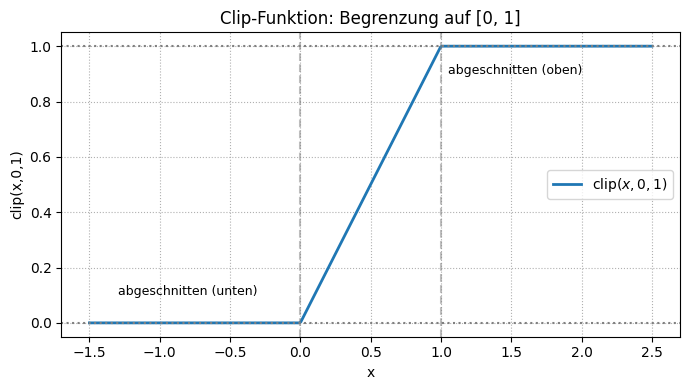

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definition der Clip-Funktion
def clip(x, a=0.0, b=1.0):
    return np.minimum(np.maximum(x, a), b)

# Wertebereich (von -1.5 bis +2.5)
x = np.linspace(-1.5, 2.5, 400)
y = clip(x, 0, 1)

# Plot
plt.figure(figsize=(7,4))
plt.plot(x, y, label=r"$\mathrm{clip}(x,0,1)$", linewidth=2)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', linestyle=':')
plt.axhline(1, color='gray', linestyle=':')
plt.text(-1.3, 0.1, "abgeschnitten (unten)", fontsize=9)
plt.text(1.05, 0.9, "abgeschnitten (oben)", fontsize=9)
plt.title("Clip-Funktion: Begrenzung auf [0, 1]")
plt.xlabel("x")
plt.ylabel("clip(x,0,1)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


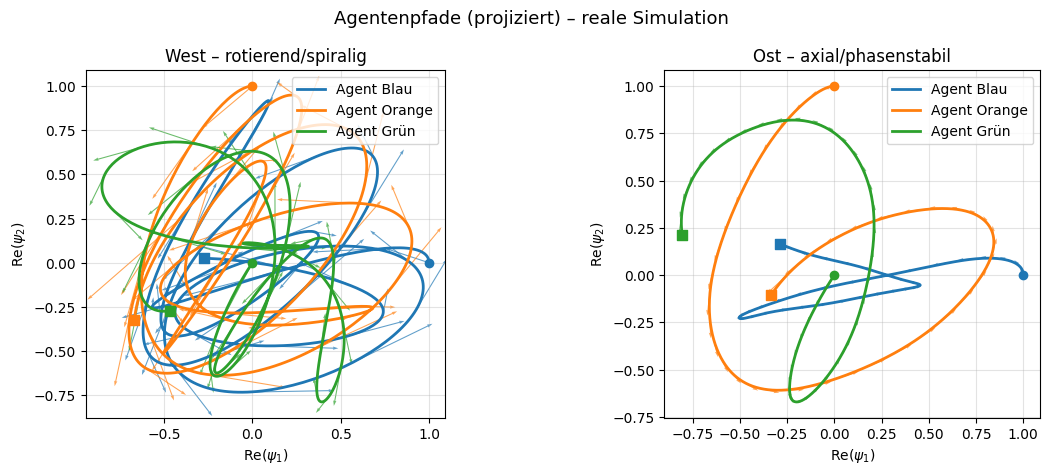

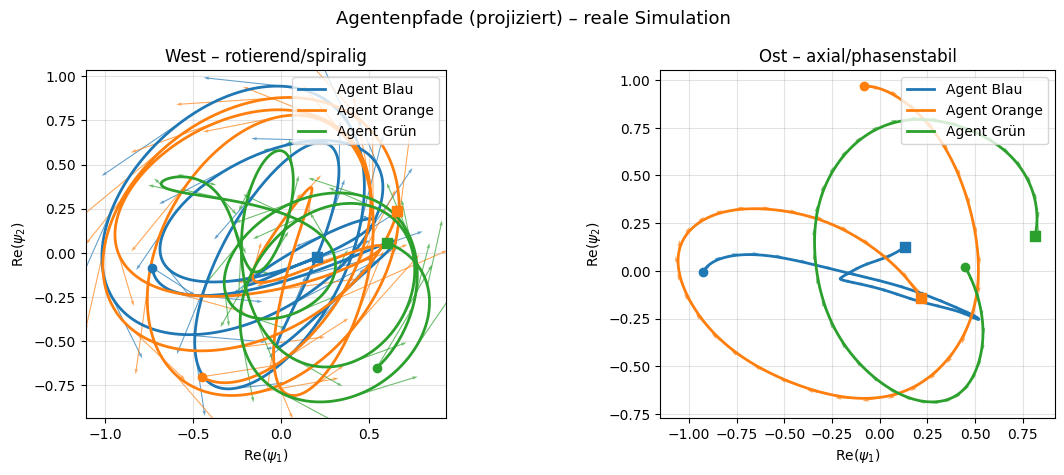

In [ ]:
# ==== ADD-ON: Real simulierte Pfade – West (rotierend) vs. Ost (axial) ==========
# Voraussetzungen aus Hauptprogramm:
# - evolve_state(psi0, s, g0, g1, t0, t1, n_eval) -> (t_eval, path[T,3] complex)
# - normalize_path(P)
# - Startzustände psiA0, psiB0, psiC0 (sonst werden sie hier gesetzt)

import numpy as np
import matplotlib.pyplot as plt

# Fallback für Startzustände
try:
    psiA0, psiB0, psiC0
except NameError:
    psiA0 = np.array([1,0,0], complex)  # Blau
    psiB0 = np.array([0,1,0], complex)  # Orange
    psiC0 = np.array([0,0,1], complex)  # Grün

# ---------- Projektion: feste Ebene (Re ψ1, Re ψ2) oder PCA auf beste 2D-Ebene ----
def project_paths_to_2d(paths, mode="plane12"):
    """
    paths: dict {'A': path[T,3], 'B': ..., 'C': ...} (complex)
    mode : 'plane12' (Re ψ1 vs. Re ψ2)  oder 'pca' (PCA auf Re-Teile)
    returns: dict mit 2D-Pfaden {'A': (X,Y), ...}
    """
    # Re-Anteile zusammenfassen
    R = np.concatenate([p.real for p in paths.values()], axis=0)  # (3T, 3)
    out = {}
    if mode == "plane12":
        for k,p in paths.items():
            XY = p.real[:, [0,1]]  # Re(ψ1), Re(ψ2)
            out[k] = (XY[:,0], XY[:,1])
        return out
    elif mode == "pca":
        # PCA auf Re-Teilen (zentriert)
        M = R - R.mean(axis=0, keepdims=True)
        U, S, Vt = np.linalg.svd(M, full_matrices=False)
        W = Vt[:2, :].T  # (3 x 2)
        for k,p in paths.items():
            XY = (p.real - R.mean(axis=0)) @ W  # (T x 2)
            out[k] = (XY[:,0], XY[:,1])
        return out
    else:
        raise ValueError("mode must be 'plane12' or 'pca'")

# ---------- kleine Hilfen zum Zeichnen -------------------------------------------
def _downsample_for_arrows(X, Y, step=30):
    idx = np.arange(0, len(X), step)
    return X[idx], Y[idx]

def _plot_single_panel(ax, XY_dict, title, colors=None):
    if colors is None:
        colors = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c'}
    labels = {'A': 'Agent Blau', 'B': 'Agent Orange', 'C': 'Agent Grün'}

    for key in ('A', 'B', 'C'):
        X, Y = XY_dict[key]
        ax.plot(X, Y, lw=2, color=colors[key], label=labels[key])
        # Start / Ende
        ax.scatter(X[0],  Y[0],  s=36, color=colors[key], zorder=3)
        ax.scatter(X[-1], Y[-1], s=60, color=colors[key], marker='s', zorder=3)
        # Richtungspfeile (ausgedünnt)
        Xa, Ya = _downsample_for_arrows(X, Y, step=max(15, len(X)//40))
        dX = np.gradient(Xa); dY = np.gradient(Ya)
        ax.quiver(Xa, Ya, dX, dY, angles='xy', scale_units='xy', scale=1.0,
                  width=0.003, color=colors[key], alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel(r"Re($\psi_1$)")
    ax.set_ylabel(r"Re($\psi_2$)")
    ax.grid(True, alpha=0.35)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc="upper right")

# ---------- Hauptfunktion ----------------------------------------------------------
def plot_real_paths_ost_west(g0=0.5, g1=1.0, t0=2000.0, t1=2025.0, n_eval=800,
                             projection="plane12", export=None):
    """
    projection: 'plane12' (Re ψ1 vs. Re ψ2) oder 'pca'
    export    : None oder Pfad-Basisname ohne Endung; speichert PNG+SVG
    """
    # WEST (s=+1)
    tW, pathA_W = evolve_state(psiA0, +1.0, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    _,  pathB_W = evolve_state(psiB0, +1.0, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    _,  pathC_W = evolve_state(psiC0, +1.0, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    pathA_W = normalize_path(pathA_W); pathB_W = normalize_path(pathB_W); pathC_W = normalize_path(pathC_W)
    paths_W = {'A': pathA_W, 'B': pathB_W, 'C': pathC_W}
    XY_W = project_paths_to_2d(paths_W, mode=projection)

    # OST (s=-1)
    tO, pathA_O = evolve_state(psiA0, -1.0, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    _,  pathB_O = evolve_state(psiB0, -1.0, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    _,  pathC_O = evolve_state(psiC0, -1.0, g0, g1, t0=t0, t1=t1, n_eval=n_eval)
    pathA_O = normalize_path(pathA_O); pathB_O = normalize_path(pathB_O); pathC_O = normalize_path(pathC_O)
    paths_O = {'A': pathA_O, 'B': pathB_O, 'C': pathC_O}
    XY_O = project_paths_to_2d(paths_O, mode=projection)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))
    _plot_single_panel(axes[0], XY_W, "West – rotierend/spiralig")
    _plot_single_panel(axes[1], XY_O, "Ost – axial/phasenstabil")
    fig.suptitle("Agentenpfade (projiziert) – reale Simulation", y=0.98, fontsize=13)
    plt.tight_layout()
    plt.show()

    if export:
        fig.savefig(f"{export}.png", dpi=200, bbox_inches="tight")
        fig.savefig(f"{export}.svg",          bbox_inches="tight")

# ---- Beispielaufrufe ---------------------------------------------------------------
# 1) Standardprojektion Re(ψ1)–Re(ψ2)
plot_real_paths_ost_west(projection="plane12", export="pfade_ost_west_plane12")

# 2) Automatische PCA-Projektion (maximale Varianz sichtbar)
plot_real_paths_ost_west(projection="pca", export="pfade_ost_west_pca")
